<a href="https://colab.research.google.com/github/IreneJeong/Project-Storage/blob/main/MLS_CW_GPy.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

A Tutorial on Bayesian Optimization
GPy - A Gaussian Process (GP) framework in Python (https://gpy.readthedocs.io/en/latest/)

In [1]:
# Install GPy, GPyOpt
!pip install GPy
!pip install GPyOpt

import tensorflow as tf
import tensorflow.keras as keras
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

import GPy
import GPyOpt
from GPyOpt.methods import BayesianOptimization

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 959.4/959.4 kB 55.0 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 71.3/71.3 kB 10.8 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for GPy: filename=GPy-1.10.0-cp39-cp39-linux_x86_64.whl size=3288070 sha256=e86fd7c54396c9911302bf3d3d18bfc2e637c2b74680b0aa91e96a0031b6de1b
  Stored in directory: /root/.cache/pip/wheels/78/fd/57/7c1e4a6f9a5380e2536af9809075ba085b1bb8d38ee84ea183
  Created wheel for paramz: filename=paramz-0.9.5-py3-none-any.whl size=102564 sha256=626cc9eff1cfa33bd2090db4a837c3dd1a3883d8046d78ab690316864e56ba57
  Stored in directory: /root/.cache/pip/wheels/9c/5f/9b/c4273ae8f869387214be2b99598d1b71dbf00672576cb85e74
Successfully built GPy paramz
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━

In [2]:
# Preprocess Data function
def preprocess_data(X, Y):
    """
    function that pre-processes the CIFAR10 dataset as per
    densenet model requirements for input images
    labels are one-hot encoded
    """
    X = keras.applications.densenet.preprocess_input(X)
    Y = keras.utils.to_categorical(Y)
    return X, Y

In [3]:
from tensorflow.keras.datasets import cifar10
# load the Cifar10 dataset, 50,000 training images
(x_train, y_train), (x_test, y_test) = cifar10.load_data()

# preprocess the data using the application's preprocess_input method and convert the labels to one-hot encodings
x_train, y_train = preprocess_data(x_train, y_train)
x_test, y_test = preprocess_data(x_test, y_test)

170498071/170498071 [==============================] - 13s 0us/step


In [4]:
input_tensor = keras.Input(shape=(32, 32, 3))

# resize images to the image size upon which the network was pre-trained
resized_images = keras.layers.Lambda(lambda image: tf.image.resize(image, (224, 224)))(input_tensor)

# Pretrained DenseNet201 (Wihtout the head classifier)
base_model = keras.applications.DenseNet201(include_top=False,
                                        weights='imagenet',
                                        input_tensor=resized_images,
                                        input_shape=(224, 224, 3),
                                        pooling='max',
                                        classes=1000)

output = base_model.layers[-1].output
base_model = keras.models.Model(inputs=input_tensor, outputs=output)

74836368/74836368 [==============================] - 4s 0us/step


Transfer learning principles are used on a DenseNet201 pre-trained CNN from the Keras API, but the same approach can be applied to other pre-trained models. Bayesian optimization is a strategy that works well for expensive-to-evaluate objective functions, such as those that govern the performance of a deep neural network. A Gaussian process is used to define the prior/posterior distribution over the objective function, and a radial basis function kernel is used for the Gaussian process. The model is optimized based on a single "satisficing" metric: validation accuracy. The hyperparameters being targeted include the number of units in the densely-connected layer, learning rate, l2 parameter for regularization, activation function for the densely-connected layer, and dropout rate for the densely-connected layer. The Bayesian surrogate model can be extended to optimize any additional hyperparameters if needed.

In [5]:
# using the training data
train_datagen = keras.preprocessing.image.ImageDataGenerator()
train_generator = train_datagen.flow(x_train,
                                     y_train,
                                     batch_size=32,
                                     shuffle=False)

features_train = base_model.predict(train_generator)

# repeat the same operation with the test data
val_datagen = keras.preprocessing.image.ImageDataGenerator()
val_generator = val_datagen.flow(x_test,
                                 y_test,
                                 batch_size=32,
                                 shuffle=False)
features_valid = base_model.predict(val_generator)

313/313 [==============================] - 40s 128ms/step


In [7]:
from tensorflow.keras.optimizers import SGD, Adam, RMSprop

In [30]:
# Define a method that builds a densely-connected head classifier, 
# given a set of hyperparameters to be optimized

def build_model(units=256, learning_rate=1e-4, l2=1e-2, activation=2, rate=0.2, opt=3):
  """function that builds a model for the head classifier"""
  # weights are initialized as per the he et al. method
  initializer = keras.initializers.he_normal()
  input_tensor = keras.Input(shape=features_train.shape[1])
  activation_dict = {1: 'relu', 2: 'elu', 3: 'tanh'}
  
  layer = keras.layers.Dense(units=units,
                         activation=activation_dict[activation],
                         kernel_initializer=initializer,
                         kernel_regularizer=keras.regularizers.l2(l2=l2)
                         )
  output = layer(input_tensor)
  dropout = keras.layers.Dropout(rate)
  output = dropout(output)
  softmax = keras.layers.Dense(units=10,
                           activation='softmax',
                           kernel_initializer=initializer,
                           kernel_regularizer=keras.regularizers.l2(l2=l2))
  output = softmax(output)
  model = keras.models.Model(inputs=input_tensor, outputs=output)

  # compile the densely-connected head classifier (here, "model")
  optimizer_dict = {0: keras.optimizers.RMSprop, 1: keras.optimizers.Adam, 2: keras.optimizers.SGD}
  optimizer = optimizer_dict[opt](learning_rate=learning_rate)
  model.compile(
           optimizer=optimizer,
           loss='categorical_crossentropy',
           metrics=['accuracy'])
  # Define some callback functions to be used by the model during training
  # reduce learning rate when val_accuracy has stopped improving
  lr_reduce = keras.callbacks.ReduceLROnPlateau(monitor='val_accuracy',
                                            factor=0.6,
                                            patience=2,
                                            verbose=1,
                                            mode='max',
                                            min_lr=1e-7)
  # stop training when val_accuracy has stopped improving
  early_stop = keras.callbacks.EarlyStopping(monitor='val_accuracy',
                                         patience=3,
                                         verbose=1,
                                         mode='max')
  # callback to save the Keras model and (best) weights obtained on an epoch basis
  checkpoint = keras.callbacks.ModelCheckpoint('cifar10.h5',
                                           monitor='val_accuracy',
                                           verbose=1,
                                           save_weights_only=False,
                                           save_best_only=True,
                                           mode='max',
                                           save_freq='epoch')
  return model, lr_reduce, early_stop, checkpoint

In [27]:
def fit_model(model, lr_reduce, early_stop, checkpoint):
  """function that trains the head classifier"""
  history = model.fit(features_train, y_train,
                      batch_size=32,
                      epochs=20,
                      verbose=0,
                      callbacks=[lr_reduce, early_stop, checkpoint],
                      validation_data=(features_valid, y_test),
                      shuffle=True)
  return history

In [28]:
def evaluate_model(model):
  """function that evaluates the head classifier"""
  evaluation = model.evaluate(features_valid, y_test)
  return evaluation


Hyperparameters: [[6.4e+01 1.0e-06 1.0e-02 1.0e+00 0.0e+00 5.0e-01]]
313/313 [==============================] - 1s 2ms/step - loss: 0.7829 - accuracy: 0.8982

Epoch 1: val_accuracy improved from -inf to 0.10740, saving model to cifar10.h5

Epoch 2: val_accuracy improved from 0.10740 to 0.14220, saving model to cifar10.h5

Epoch 3: val_accuracy improved from 0.14220 to 0.17150, saving model to cifar10.h5

Epoch 4: val_accuracy improved from 0.17150 to 0.19680, saving model to cifar10.h5

Epoch 5: val_accuracy improved from 0.19680 to 0.22060, saving model to cifar10.h5

Epoch 6: val_accuracy improved from 0.22060 to 0.23720, saving model to cifar10.h5

Epoch 7: val_accuracy improved from 0.23720 to 0.25760, saving model to cifar10.h5

Epoch 8: val_accuracy improved from 0.25760 to 0.27900, saving model to cifar10.h5

Epoch 9: val_accuracy improved from 0.27900 to 0.30110, saving model to cifar10.h5

Epoch 10: val_accuracy improved from 0.30110 to 0.32360, saving model to cifar10.h5

Ep

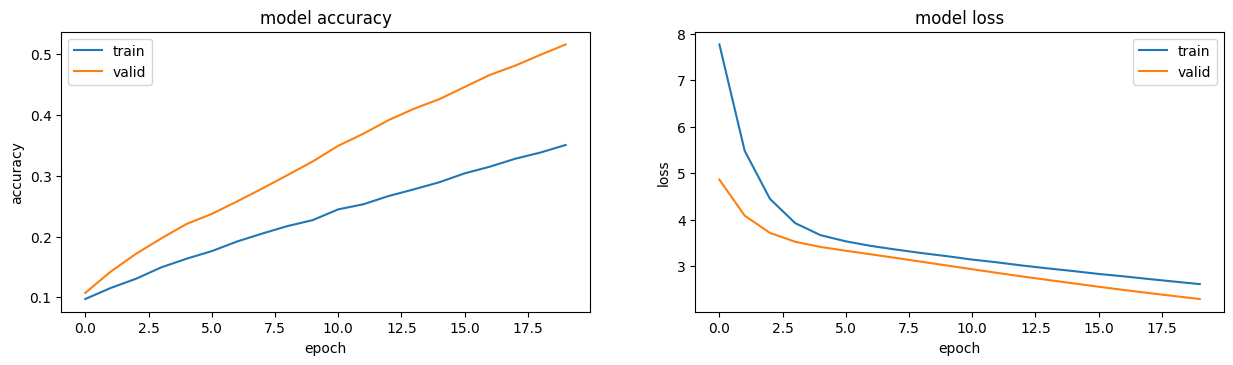


Hyperparameters: [[5.12e+02 1.00e-03 1.00e-02 3.00e+00 0.00e+00 7.00e-01]]
313/313 [==============================] - 1s 2ms/step - loss: 0.7829 - accuracy: 0.8982

Epoch 1: val_accuracy improved from -inf to 0.84640, saving model to cifar10.h5

Epoch 2: val_accuracy did not improve from 0.84640

Epoch 3: val_accuracy improved from 0.84640 to 0.85460, saving model to cifar10.h5

Epoch 4: val_accuracy did not improve from 0.85460

Epoch 5: ReduceLROnPlateau reducing learning rate to 0.0006000000284984708.

Epoch 5: val_accuracy did not improve from 0.85460

Epoch 6: val_accuracy improved from 0.85460 to 0.86120, saving model to cifar10.h5

Epoch 7: val_accuracy improved from 0.86120 to 0.87680, saving model to cifar10.h5

Epoch 8: val_accuracy did not improve from 0.87680

Epoch 9: ReduceLROnPlateau reducing learning rate to 0.0003600000170990825.

Epoch 9: val_accuracy did not improve from 0.87680

Epoch 10: val_accuracy improved from 0.87680 to 0.87920, saving model to cifar10.h5

Ep

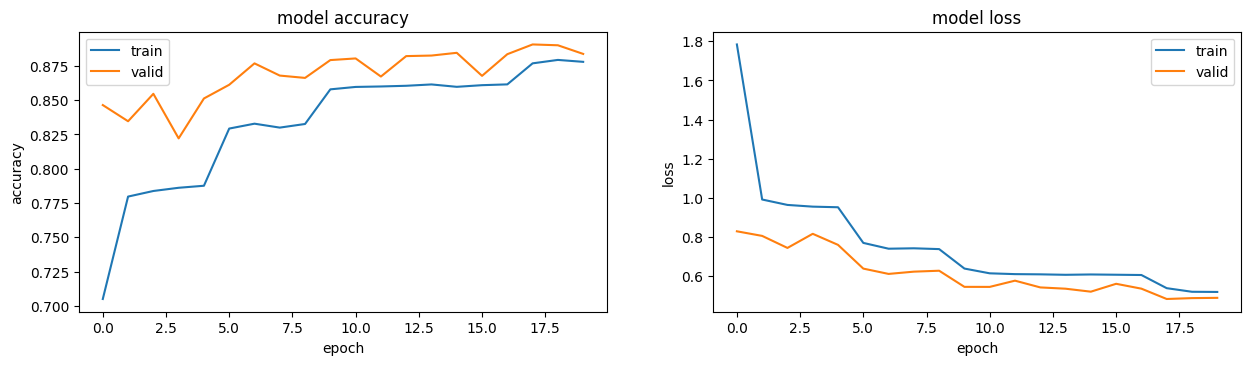


Hyperparameters: [[1.28e+02 1.00e-05 1.00e-01 3.00e+00 0.00e+00 2.00e-01]]
313/313 [==============================] - 1s 2ms/step - loss: 0.7829 - accuracy: 0.8982

Epoch 1: val_accuracy improved from -inf to 0.70780, saving model to cifar10.h5

Epoch 2: val_accuracy improved from 0.70780 to 0.80010, saving model to cifar10.h5

Epoch 3: val_accuracy improved from 0.80010 to 0.82890, saving model to cifar10.h5

Epoch 4: val_accuracy improved from 0.82890 to 0.85140, saving model to cifar10.h5

Epoch 5: val_accuracy improved from 0.85140 to 0.86210, saving model to cifar10.h5

Epoch 6: val_accuracy improved from 0.86210 to 0.86830, saving model to cifar10.h5

Epoch 7: val_accuracy improved from 0.86830 to 0.87380, saving model to cifar10.h5

Epoch 8: val_accuracy improved from 0.87380 to 0.87630, saving model to cifar10.h5

Epoch 9: val_accuracy improved from 0.87630 to 0.87720, saving model to cifar10.h5

Epoch 10: val_accuracy improved from 0.87720 to 0.88020, saving model to cifar10.

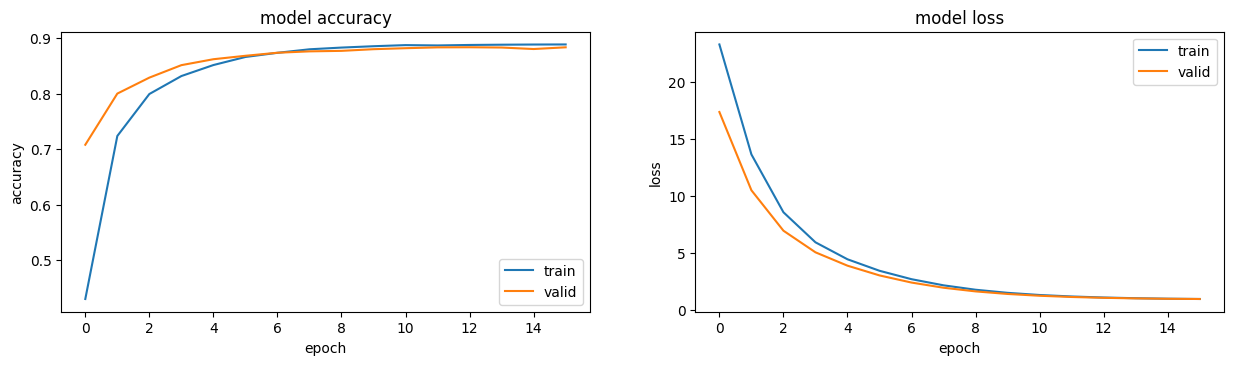


Hyperparameters: [[6.4e+01 1.0e-03 1.0e-01 3.0e+00 0.0e+00 5.0e-01]]
313/313 [==============================] - 1s 2ms/step - loss: 0.7829 - accuracy: 0.8982

Epoch 1: val_accuracy improved from -inf to 0.81900, saving model to cifar10.h5

Epoch 2: val_accuracy did not improve from 0.81900

Epoch 3: val_accuracy improved from 0.81900 to 0.83420, saving model to cifar10.h5

Epoch 4: val_accuracy did not improve from 0.83420

Epoch 5: ReduceLROnPlateau reducing learning rate to 0.0006000000284984708.

Epoch 5: val_accuracy did not improve from 0.83420

Epoch 6: val_accuracy did not improve from 0.83420
Epoch 6: early stopping
313/313 [==============================] - 1s 2ms/step - loss: 1.2453 - accuracy: 0.8228

LOSS:	1.2453352212905884 	 ACCURACY:	0.8227999806404114
[1.2453352212905884, 0.8227999806404114]



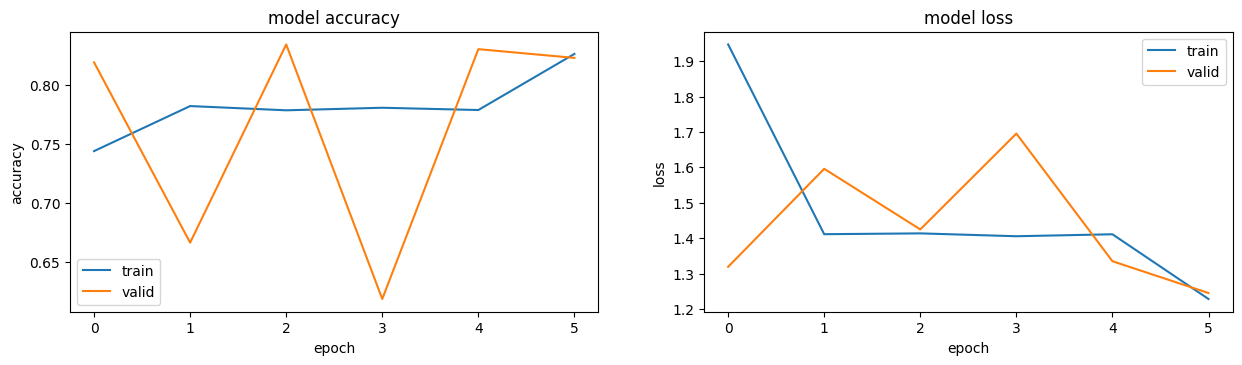


Hyperparameters: [[1.28e+02 1.00e-05 1.00e-01 3.00e+00 1.00e+00 2.00e-01]]
313/313 [==============================] - 1s 2ms/step - loss: 0.7829 - accuracy: 0.8982

Epoch 1: val_accuracy improved from -inf to 0.66870, saving model to cifar10.h5

Epoch 2: val_accuracy improved from 0.66870 to 0.78630, saving model to cifar10.h5

Epoch 3: val_accuracy improved from 0.78630 to 0.82570, saving model to cifar10.h5

Epoch 4: val_accuracy improved from 0.82570 to 0.84890, saving model to cifar10.h5

Epoch 5: val_accuracy improved from 0.84890 to 0.86270, saving model to cifar10.h5

Epoch 6: val_accuracy improved from 0.86270 to 0.86900, saving model to cifar10.h5

Epoch 7: val_accuracy improved from 0.86900 to 0.87310, saving model to cifar10.h5

Epoch 8: val_accuracy improved from 0.87310 to 0.87650, saving model to cifar10.h5

Epoch 9: val_accuracy improved from 0.87650 to 0.87950, saving model to cifar10.h5

Epoch 10: val_accuracy improved from 0.87950 to 0.88060, saving model to cifar10.

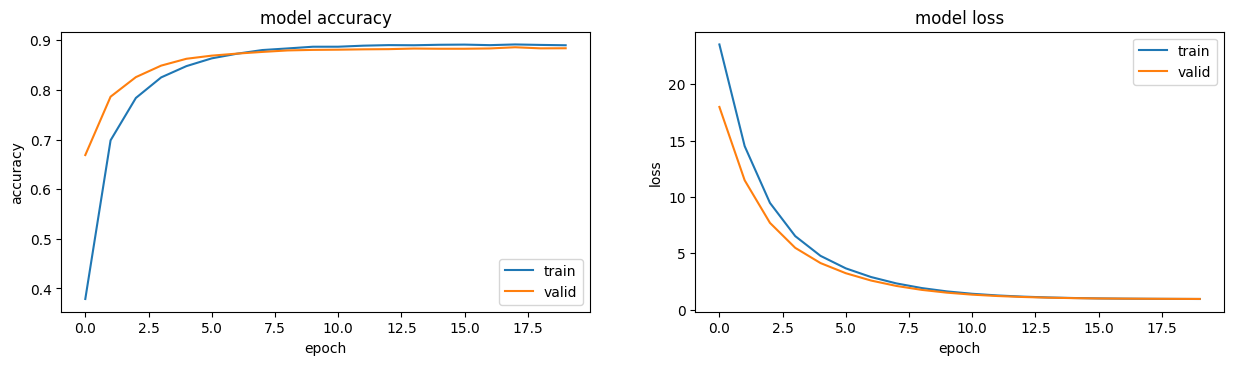




Hyperparameters: [[5.12e+02 1.00e-05 1.00e-01 3.00e+00 1.00e+00 7.00e-01]]
313/313 [==============================] - 1s 2ms/step - loss: 0.7829 - accuracy: 0.8982

Epoch 1: val_accuracy improved from -inf to 0.73420, saving model to cifar10.h5

Epoch 2: val_accuracy improved from 0.73420 to 0.81040, saving model to cifar10.h5

Epoch 3: val_accuracy improved from 0.81040 to 0.83770, saving model to cifar10.h5

Epoch 4: val_accuracy improved from 0.83770 to 0.85250, saving model to cifar10.h5

Epoch 5: val_accuracy improved from 0.85250 to 0.86350, saving model to cifar10.h5

Epoch 6: val_accuracy improved from 0.86350 to 0.87250, saving model to cifar10.h5

Epoch 7: val_accuracy improved from 0.87250 to 0.87630, saving model to cifar10.h5

Epoch 8: val_accuracy improved from 0.87630 to 0.87950, saving model to cifar10.h5

Epoch 9: val_accuracy improved from 0.87950 to 0.88430, saving model to cifar10.h5

Epoch 10: val_accuracy did not improve from 0.88430

Epoch 11: val_accuracy imp

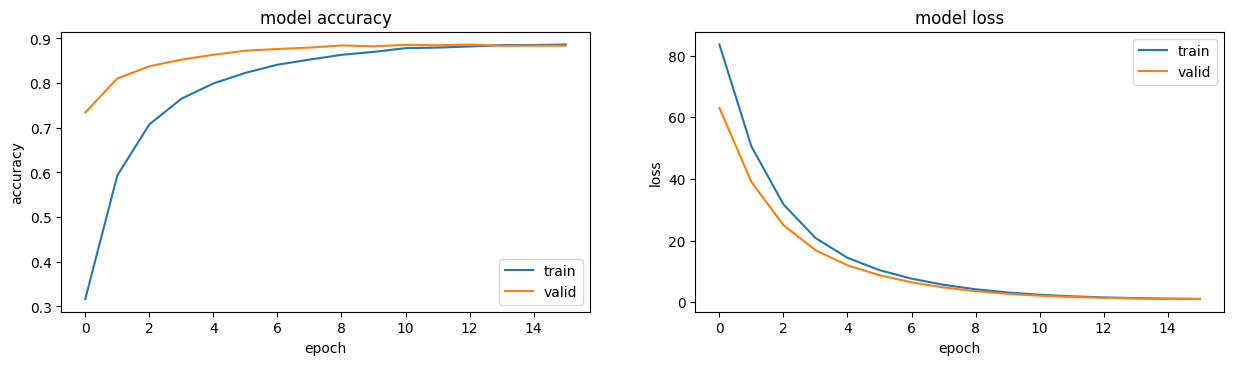


Hyperparameters: [[2.56e+02 1.00e-03 1.00e-02 1.00e+00 0.00e+00 5.00e-01]]
313/313 [==============================] - 1s 2ms/step - loss: 0.7829 - accuracy: 0.8982

Epoch 1: val_accuracy improved from -inf to 0.85090, saving model to cifar10.h5

Epoch 2: val_accuracy improved from 0.85090 to 0.86330, saving model to cifar10.h5

Epoch 3: val_accuracy improved from 0.86330 to 0.86490, saving model to cifar10.h5

Epoch 4: val_accuracy did not improve from 0.86490

Epoch 5: ReduceLROnPlateau reducing learning rate to 0.0006000000284984708.

Epoch 5: val_accuracy did not improve from 0.86490

Epoch 6: val_accuracy improved from 0.86490 to 0.86710, saving model to cifar10.h5

Epoch 7: val_accuracy did not improve from 0.86710

Epoch 8: val_accuracy improved from 0.86710 to 0.87670, saving model to cifar10.h5

Epoch 9: val_accuracy did not improve from 0.87670

Epoch 10: ReduceLROnPlateau reducing learning rate to 0.0003600000170990825.

Epoch 10: val_accuracy did not improve from 0.87670

E

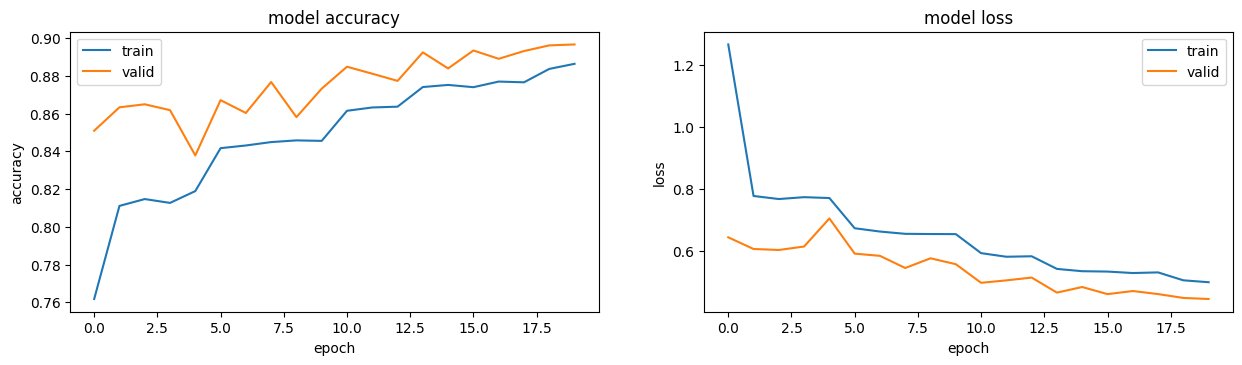


Hyperparameters: [[2.56e+02 1.00e-05 1.00e-03 3.00e+00 1.00e+00 5.00e-01]]
313/313 [==============================] - 1s 2ms/step - loss: 0.7829 - accuracy: 0.8982

Epoch 1: val_accuracy improved from -inf to 0.71780, saving model to cifar10.h5

Epoch 2: val_accuracy improved from 0.71780 to 0.79410, saving model to cifar10.h5

Epoch 3: val_accuracy improved from 0.79410 to 0.82570, saving model to cifar10.h5

Epoch 4: val_accuracy improved from 0.82570 to 0.84280, saving model to cifar10.h5

Epoch 5: val_accuracy improved from 0.84280 to 0.85210, saving model to cifar10.h5

Epoch 6: val_accuracy improved from 0.85210 to 0.85930, saving model to cifar10.h5

Epoch 7: val_accuracy improved from 0.85930 to 0.86400, saving model to cifar10.h5

Epoch 8: val_accuracy improved from 0.86400 to 0.86800, saving model to cifar10.h5

Epoch 9: val_accuracy improved from 0.86800 to 0.87070, saving model to cifar10.h5

Epoch 10: val_accuracy improved from 0.87070 to 0.87310, saving model to cifar10.

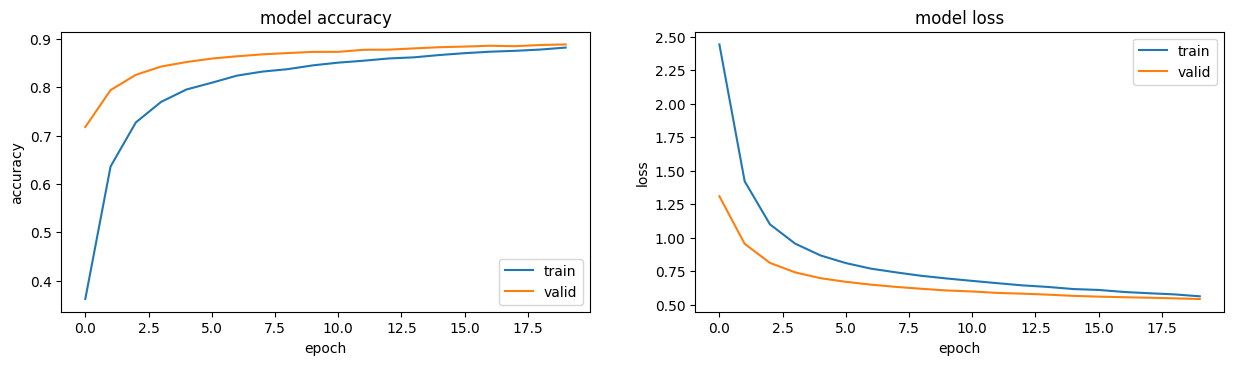


Hyperparameters: [[2.56e+02 1.00e-03 1.00e-03 2.00e+00 1.00e+00 2.00e-01]]
313/313 [==============================] - 1s 2ms/step - loss: 0.7829 - accuracy: 0.8982

Epoch 1: val_accuracy improved from -inf to 0.88120, saving model to cifar10.h5

Epoch 2: val_accuracy improved from 0.88120 to 0.88380, saving model to cifar10.h5

Epoch 3: val_accuracy improved from 0.88380 to 0.89390, saving model to cifar10.h5

Epoch 4: val_accuracy did not improve from 0.89390

Epoch 5: ReduceLROnPlateau reducing learning rate to 0.0006000000284984708.

Epoch 5: val_accuracy did not improve from 0.89390

Epoch 6: val_accuracy improved from 0.89390 to 0.89850, saving model to cifar10.h5

Epoch 7: val_accuracy improved from 0.89850 to 0.90130, saving model to cifar10.h5

Epoch 8: val_accuracy improved from 0.90130 to 0.90220, saving model to cifar10.h5

Epoch 9: val_accuracy did not improve from 0.90220

Epoch 10: ReduceLROnPlateau reducing learning rate to 0.0003600000170990825.

Epoch 10: val_accuracy

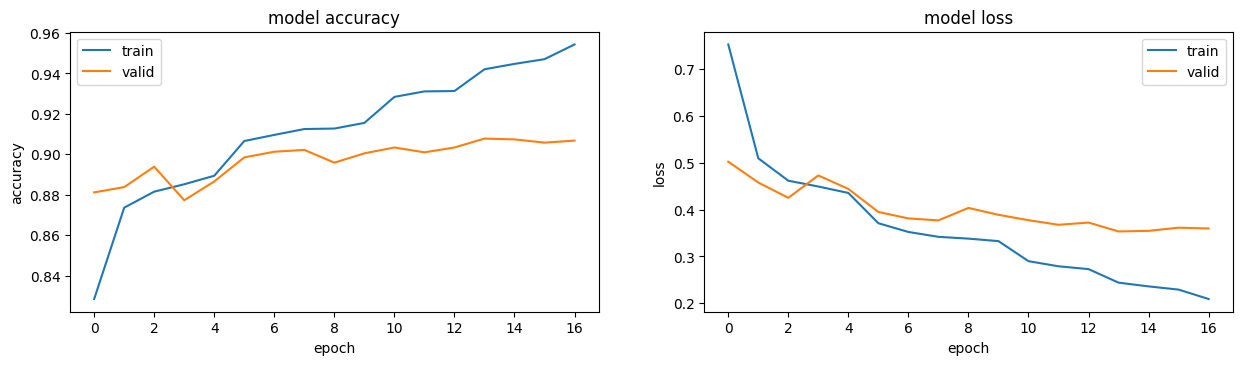


Hyperparameters: [[2.56e+02 1.00e-05 1.00e-01 3.00e+00 1.00e+00 7.00e-01]]
313/313 [==============================] - 1s 2ms/step - loss: 0.3596 - accuracy: 0.9068

Epoch 1: val_accuracy improved from -inf to 0.65180, saving model to cifar10.h5

Epoch 2: val_accuracy improved from 0.65180 to 0.78040, saving model to cifar10.h5

Epoch 3: val_accuracy improved from 0.78040 to 0.81910, saving model to cifar10.h5

Epoch 4: val_accuracy improved from 0.81910 to 0.84210, saving model to cifar10.h5

Epoch 5: val_accuracy improved from 0.84210 to 0.85260, saving model to cifar10.h5

Epoch 6: val_accuracy improved from 0.85260 to 0.86110, saving model to cifar10.h5

Epoch 7: val_accuracy improved from 0.86110 to 0.86480, saving model to cifar10.h5

Epoch 8: val_accuracy improved from 0.86480 to 0.87300, saving model to cifar10.h5

Epoch 9: val_accuracy improved from 0.87300 to 0.87660, saving model to cifar10.h5

Epoch 10: val_accuracy improved from 0.87660 to 0.87900, saving model to cifar10.

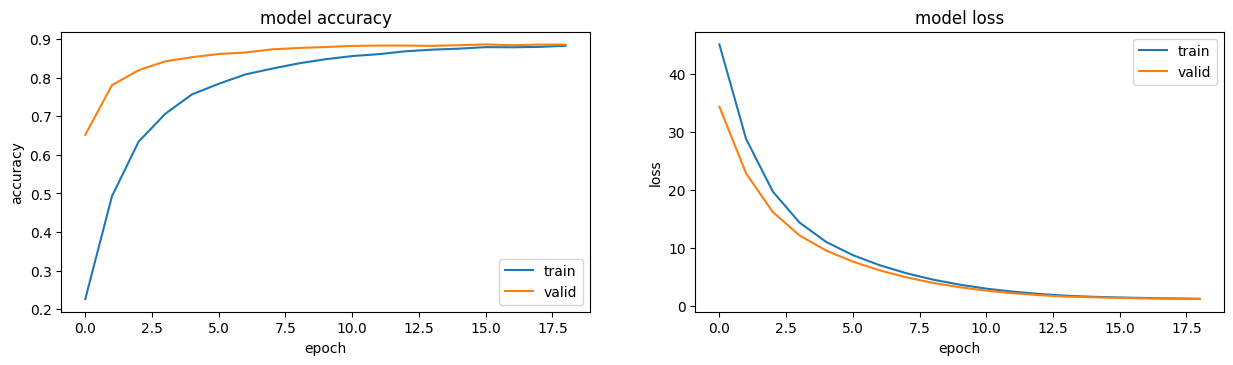


Hyperparameters: [[2.56e+02 1.00e-03 1.00e-02 1.00e+00 1.00e+00 7.00e-01]]
313/313 [==============================] - 1s 2ms/step - loss: 0.3596 - accuracy: 0.9068

Epoch 1: val_accuracy improved from -inf to 0.87250, saving model to cifar10.h5

Epoch 2: val_accuracy did not improve from 0.87250

Epoch 3: ReduceLROnPlateau reducing learning rate to 0.0006000000284984708.

Epoch 3: val_accuracy did not improve from 0.87250

Epoch 4: val_accuracy improved from 0.87250 to 0.87960, saving model to cifar10.h5

Epoch 5: val_accuracy improved from 0.87960 to 0.88210, saving model to cifar10.h5

Epoch 6: val_accuracy did not improve from 0.88210

Epoch 7: ReduceLROnPlateau reducing learning rate to 0.0003600000170990825.

Epoch 7: val_accuracy did not improve from 0.88210

Epoch 8: val_accuracy did not improve from 0.88210
Epoch 8: early stopping
313/313 [==============================] - 1s 2ms/step - loss: 0.5369 - accuracy: 0.8743

LOSS:	0.5368606448173523 	 ACCURACY:	0.8743000030517578
[0

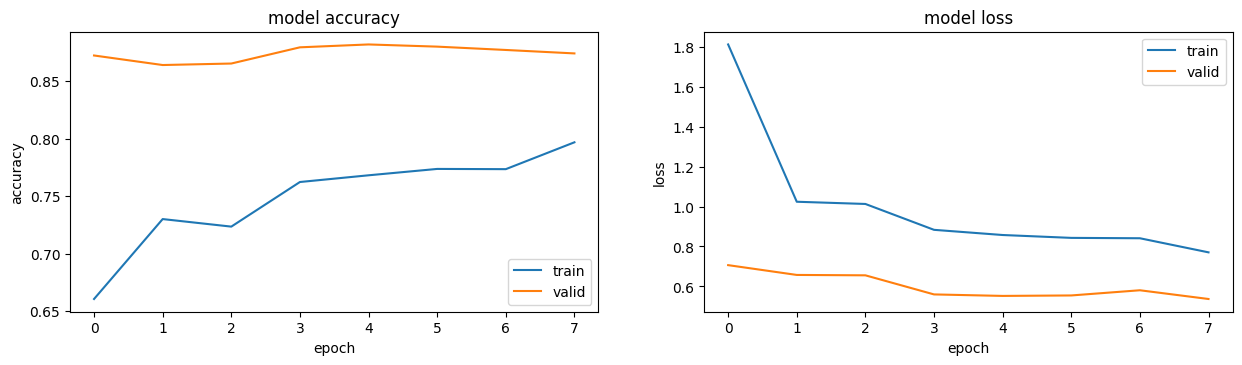


Hyperparameters: [[1.28e+02 1.00e-03 1.00e-01 2.00e+00 2.00e+00 7.00e-01]]
313/313 [==============================] - 1s 2ms/step - loss: 0.3596 - accuracy: 0.9068

Epoch 1: val_accuracy improved from -inf to 0.84160, saving model to cifar10.h5

Epoch 2: val_accuracy improved from 0.84160 to 0.86560, saving model to cifar10.h5

Epoch 3: val_accuracy improved from 0.86560 to 0.87340, saving model to cifar10.h5

Epoch 4: val_accuracy improved from 0.87340 to 0.87760, saving model to cifar10.h5

Epoch 5: val_accuracy improved from 0.87760 to 0.87870, saving model to cifar10.h5

Epoch 6: val_accuracy did not improve from 0.87870

Epoch 7: val_accuracy improved from 0.87870 to 0.88130, saving model to cifar10.h5

Epoch 8: val_accuracy did not improve from 0.88130

Epoch 9: ReduceLROnPlateau reducing learning rate to 0.0006000000284984708.

Epoch 9: val_accuracy did not improve from 0.88130

Epoch 10: val_accuracy did not improve from 0.88130
Epoch 10: early stopping
313/313 [==============

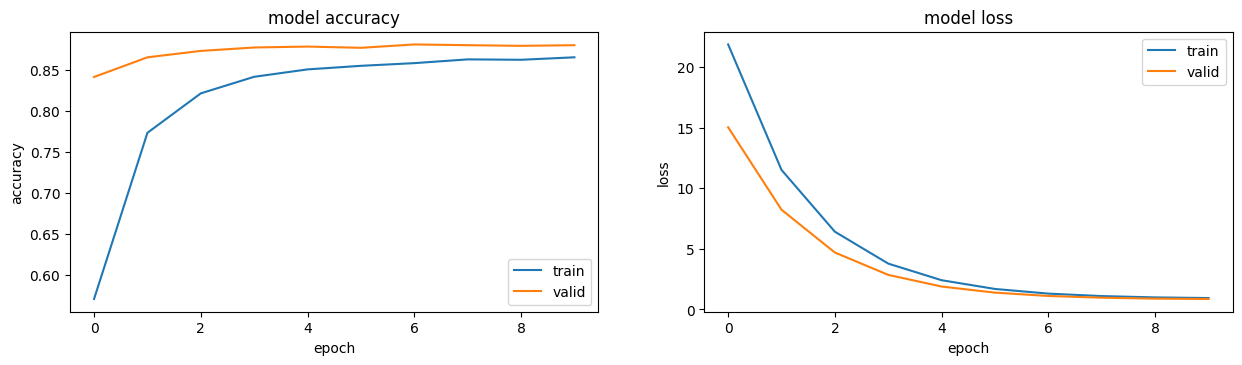


Hyperparameters: [[5.12e+02 1.00e-04 1.00e-02 1.00e+00 1.00e+00 2.00e-01]]
313/313 [==============================] - 1s 2ms/step - loss: 0.3596 - accuracy: 0.9068

Epoch 1: val_accuracy improved from -inf to 0.87170, saving model to cifar10.h5

Epoch 2: val_accuracy improved from 0.87170 to 0.89160, saving model to cifar10.h5

Epoch 3: val_accuracy improved from 0.89160 to 0.89400, saving model to cifar10.h5

Epoch 4: val_accuracy did not improve from 0.89400

Epoch 5: val_accuracy improved from 0.89400 to 0.89930, saving model to cifar10.h5

Epoch 6: val_accuracy did not improve from 0.89930

Epoch 7: ReduceLROnPlateau reducing learning rate to 5.999999848427251e-05.

Epoch 7: val_accuracy did not improve from 0.89930

Epoch 8: val_accuracy improved from 0.89930 to 0.90210, saving model to cifar10.h5

Epoch 9: val_accuracy did not improve from 0.90210

Epoch 10: ReduceLROnPlateau reducing learning rate to 3.599999909056351e-05.

Epoch 10: val_accuracy did not improve from 0.90210

E

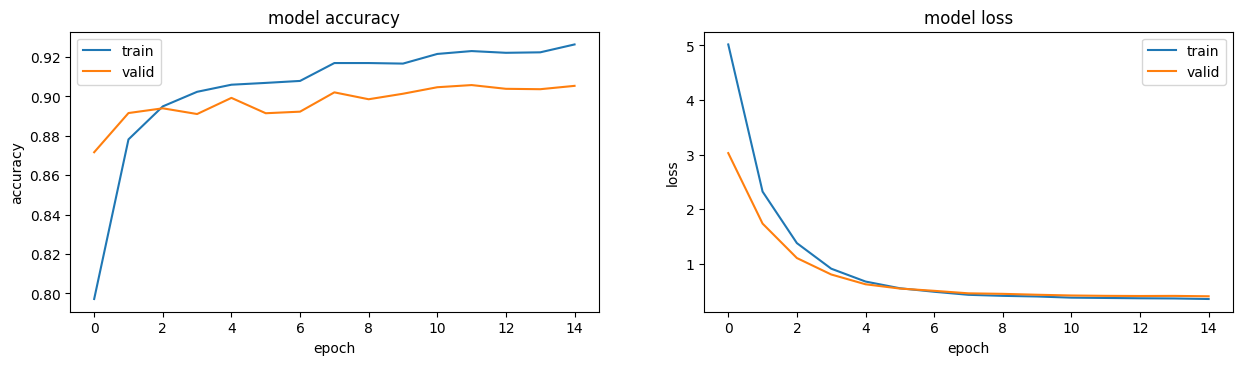


Hyperparameters: [[5.12e+02 1.00e-06 1.00e-02 3.00e+00 0.00e+00 2.00e-01]]
313/313 [==============================] - 1s 2ms/step - loss: 0.3596 - accuracy: 0.9068

Epoch 1: val_accuracy improved from -inf to 0.31140, saving model to cifar10.h5

Epoch 2: val_accuracy improved from 0.31140 to 0.49680, saving model to cifar10.h5

Epoch 3: val_accuracy improved from 0.49680 to 0.60870, saving model to cifar10.h5

Epoch 4: val_accuracy improved from 0.60870 to 0.67080, saving model to cifar10.h5

Epoch 5: val_accuracy improved from 0.67080 to 0.71140, saving model to cifar10.h5

Epoch 6: val_accuracy improved from 0.71140 to 0.73980, saving model to cifar10.h5

Epoch 7: val_accuracy improved from 0.73980 to 0.76040, saving model to cifar10.h5

Epoch 8: val_accuracy improved from 0.76040 to 0.77460, saving model to cifar10.h5

Epoch 9: val_accuracy improved from 0.77460 to 0.78490, saving model to cifar10.h5

Epoch 10: val_accuracy improved from 0.78490 to 0.79490, saving model to cifar10.

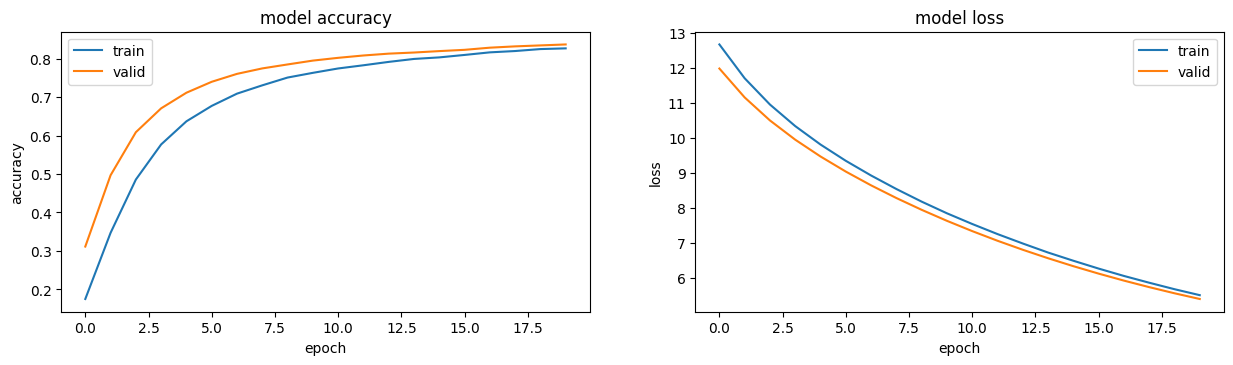


Hyperparameters: [[2.56e+02 1.00e-05 1.00e-02 1.00e+00 2.00e+00 2.00e-01]]
313/313 [==============================] - 1s 2ms/step - loss: 0.3596 - accuracy: 0.9068

Epoch 1: val_accuracy improved from -inf to 0.21560, saving model to cifar10.h5

Epoch 2: val_accuracy improved from 0.21560 to 0.32670, saving model to cifar10.h5

Epoch 3: val_accuracy improved from 0.32670 to 0.41480, saving model to cifar10.h5

Epoch 4: val_accuracy improved from 0.41480 to 0.48170, saving model to cifar10.h5

Epoch 5: val_accuracy improved from 0.48170 to 0.53560, saving model to cifar10.h5

Epoch 6: val_accuracy improved from 0.53560 to 0.57490, saving model to cifar10.h5

Epoch 7: val_accuracy improved from 0.57490 to 0.60690, saving model to cifar10.h5

Epoch 8: val_accuracy improved from 0.60690 to 0.63180, saving model to cifar10.h5

Epoch 9: val_accuracy improved from 0.63180 to 0.65120, saving model to cifar10.h5

Epoch 10: val_accuracy improved from 0.65120 to 0.66900, saving model to cifar10.

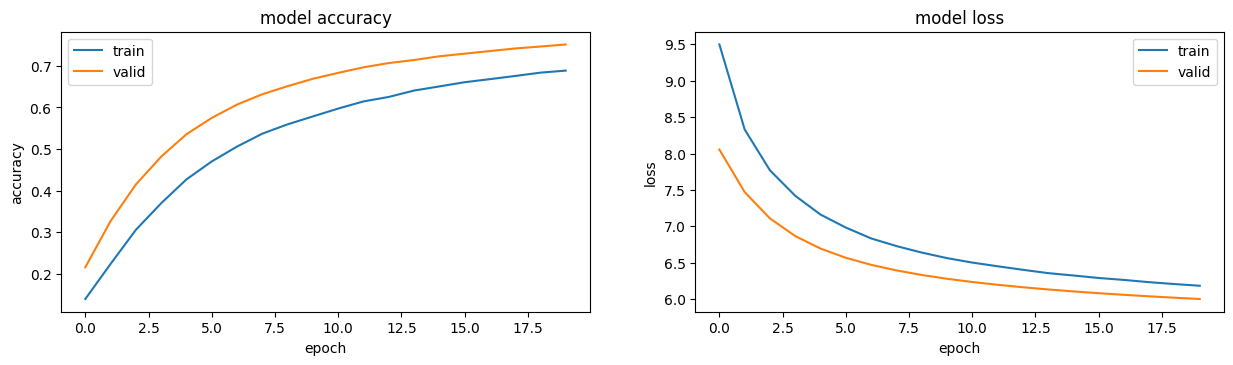


Hyperparameters: [[1.28e+02 1.00e-04 1.00e-01 3.00e+00 0.00e+00 2.00e-01]]
313/313 [==============================] - 1s 2ms/step - loss: 0.3596 - accuracy: 0.9068

Epoch 1: val_accuracy improved from -inf to 0.86350, saving model to cifar10.h5

Epoch 2: val_accuracy improved from 0.86350 to 0.87130, saving model to cifar10.h5

Epoch 3: val_accuracy improved from 0.87130 to 0.87250, saving model to cifar10.h5

Epoch 4: val_accuracy improved from 0.87250 to 0.87540, saving model to cifar10.h5

Epoch 5: val_accuracy did not improve from 0.87540

Epoch 6: ReduceLROnPlateau reducing learning rate to 5.999999848427251e-05.

Epoch 6: val_accuracy did not improve from 0.87540

Epoch 7: val_accuracy improved from 0.87540 to 0.87980, saving model to cifar10.h5

Epoch 8: val_accuracy improved from 0.87980 to 0.88150, saving model to cifar10.h5

Epoch 9: val_accuracy did not improve from 0.88150

Epoch 10: ReduceLROnPlateau reducing learning rate to 3.599999909056351e-05.

Epoch 10: val_accuracy

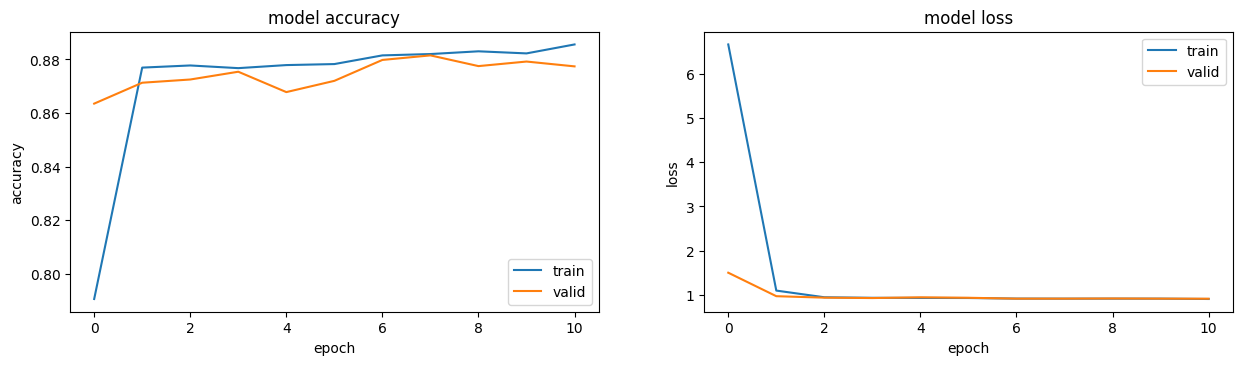


Hyperparameters: [[1.28e+02 1.00e-03 1.00e-01 2.00e+00 0.00e+00 2.00e-01]]
313/313 [==============================] - 1s 2ms/step - loss: 0.3596 - accuracy: 0.9068

Epoch 1: val_accuracy improved from -inf to 0.67710, saving model to cifar10.h5

Epoch 2: val_accuracy improved from 0.67710 to 0.80600, saving model to cifar10.h5

Epoch 3: val_accuracy improved from 0.80600 to 0.81470, saving model to cifar10.h5

Epoch 4: val_accuracy did not improve from 0.81470

Epoch 5: ReduceLROnPlateau reducing learning rate to 0.0006000000284984708.

Epoch 5: val_accuracy did not improve from 0.81470

Epoch 6: val_accuracy did not improve from 0.81470
Epoch 6: early stopping
313/313 [==============================] - 1s 2ms/step - loss: 0.9736 - accuracy: 0.8054

LOSS:	0.9736016392707825 	 ACCURACY:	0.805400013923645
[0.9736016392707825, 0.805400013923645]



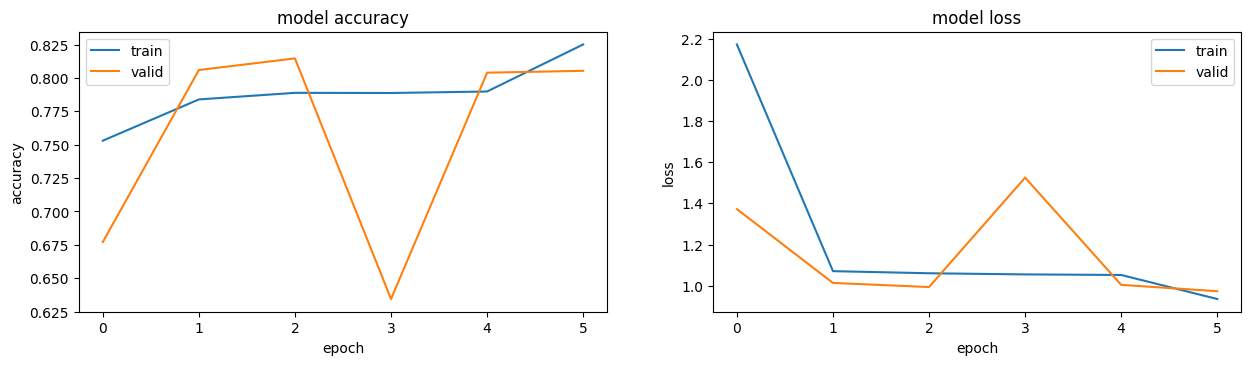


Hyperparameters: [[5.12e+02 1.00e-06 1.00e-03 1.00e+00 0.00e+00 5.00e-01]]
313/313 [==============================] - 1s 2ms/step - loss: 0.3596 - accuracy: 0.9068

Epoch 1: val_accuracy improved from -inf to 0.27130, saving model to cifar10.h5

Epoch 2: val_accuracy improved from 0.27130 to 0.43830, saving model to cifar10.h5

Epoch 3: val_accuracy improved from 0.43830 to 0.54840, saving model to cifar10.h5

Epoch 4: val_accuracy improved from 0.54840 to 0.62530, saving model to cifar10.h5

Epoch 5: val_accuracy improved from 0.62530 to 0.67320, saving model to cifar10.h5

Epoch 6: val_accuracy improved from 0.67320 to 0.70670, saving model to cifar10.h5

Epoch 7: val_accuracy improved from 0.70670 to 0.72780, saving model to cifar10.h5

Epoch 8: val_accuracy improved from 0.72780 to 0.74590, saving model to cifar10.h5

Epoch 9: val_accuracy improved from 0.74590 to 0.75930, saving model to cifar10.h5

Epoch 10: val_accuracy improved from 0.75930 to 0.76830, saving model to cifar10.

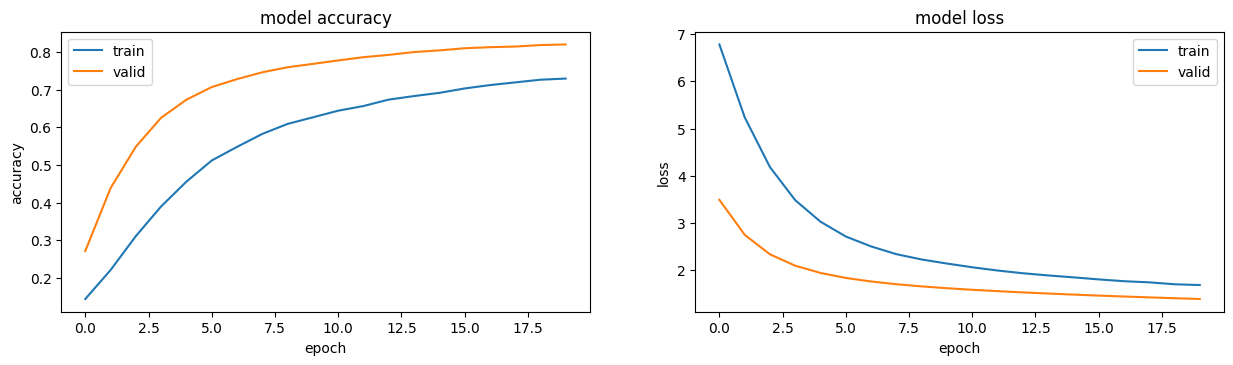


Hyperparameters: [[2.56e+02 1.00e-05 1.00e-01 2.00e+00 2.00e+00 2.00e-01]]
313/313 [==============================] - 1s 2ms/step - loss: 0.3596 - accuracy: 0.9068

Epoch 1: val_accuracy improved from -inf to 0.23140, saving model to cifar10.h5

Epoch 2: val_accuracy improved from 0.23140 to 0.35610, saving model to cifar10.h5

Epoch 3: val_accuracy improved from 0.35610 to 0.46180, saving model to cifar10.h5

Epoch 4: val_accuracy improved from 0.46180 to 0.53110, saving model to cifar10.h5

Epoch 5: val_accuracy improved from 0.53110 to 0.58030, saving model to cifar10.h5

Epoch 6: val_accuracy improved from 0.58030 to 0.61770, saving model to cifar10.h5

Epoch 7: val_accuracy improved from 0.61770 to 0.64750, saving model to cifar10.h5

Epoch 8: val_accuracy improved from 0.64750 to 0.67090, saving model to cifar10.h5

Epoch 9: val_accuracy improved from 0.67090 to 0.68720, saving model to cifar10.h5

Epoch 10: val_accuracy improved from 0.68720 to 0.70220, saving model to cifar10.

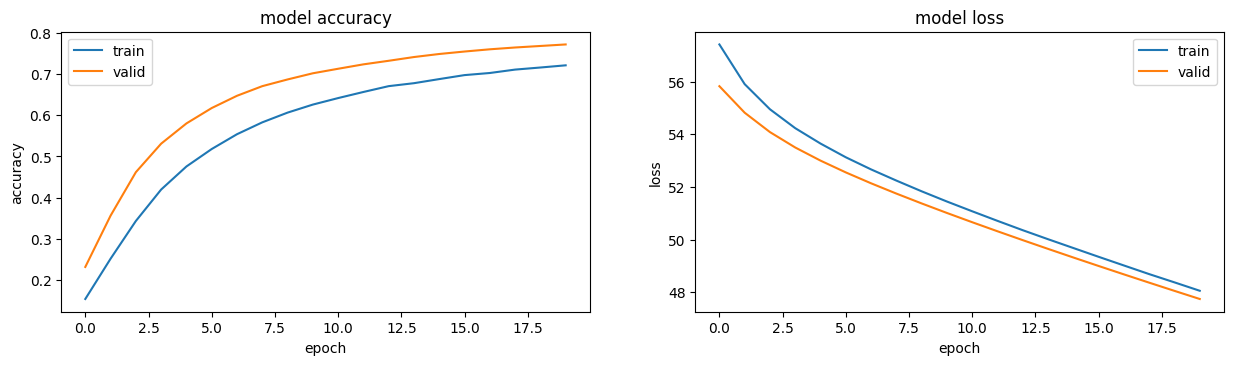


Hyperparameters: [[1.28e+02 1.00e-03 1.00e-02 3.00e+00 1.00e+00 2.00e-01]]
313/313 [==============================] - 1s 2ms/step - loss: 0.3596 - accuracy: 0.9068

Epoch 1: val_accuracy improved from -inf to 0.85390, saving model to cifar10.h5

Epoch 2: val_accuracy improved from 0.85390 to 0.86620, saving model to cifar10.h5

Epoch 3: val_accuracy did not improve from 0.86620

Epoch 4: ReduceLROnPlateau reducing learning rate to 0.0006000000284984708.

Epoch 4: val_accuracy did not improve from 0.86620

Epoch 5: val_accuracy improved from 0.86620 to 0.86810, saving model to cifar10.h5

Epoch 6: val_accuracy improved from 0.86810 to 0.88330, saving model to cifar10.h5

Epoch 7: val_accuracy improved from 0.88330 to 0.88370, saving model to cifar10.h5

Epoch 8: val_accuracy did not improve from 0.88370

Epoch 9: ReduceLROnPlateau reducing learning rate to 0.0003600000170990825.

Epoch 9: val_accuracy did not improve from 0.88370

Epoch 10: val_accuracy improved from 0.88370 to 0.88510

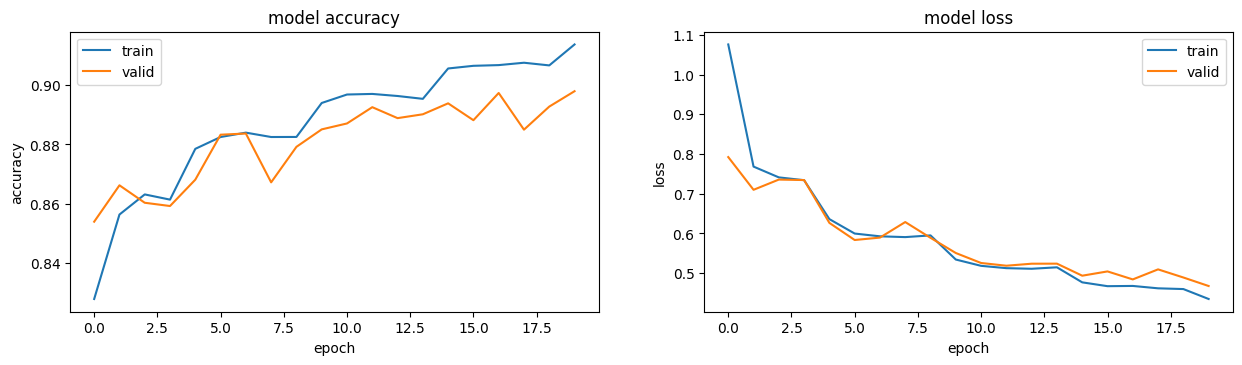


Hyperparameters: [[1.28e+02 1.00e-03 1.00e-03 2.00e+00 2.00e+00 7.00e-01]]
313/313 [==============================] - 1s 2ms/step - loss: 0.3596 - accuracy: 0.9068

Epoch 1: val_accuracy improved from -inf to 0.83880, saving model to cifar10.h5

Epoch 2: val_accuracy improved from 0.83880 to 0.85820, saving model to cifar10.h5

Epoch 3: val_accuracy improved from 0.85820 to 0.86860, saving model to cifar10.h5

Epoch 4: val_accuracy improved from 0.86860 to 0.87230, saving model to cifar10.h5

Epoch 5: val_accuracy improved from 0.87230 to 0.87790, saving model to cifar10.h5

Epoch 6: val_accuracy improved from 0.87790 to 0.88070, saving model to cifar10.h5

Epoch 7: val_accuracy did not improve from 0.88070

Epoch 8: val_accuracy improved from 0.88070 to 0.88560, saving model to cifar10.h5

Epoch 9: val_accuracy did not improve from 0.88560

Epoch 10: val_accuracy improved from 0.88560 to 0.88670, saving model to cifar10.h5

Epoch 11: val_accuracy improved from 0.88670 to 0.88800, sav

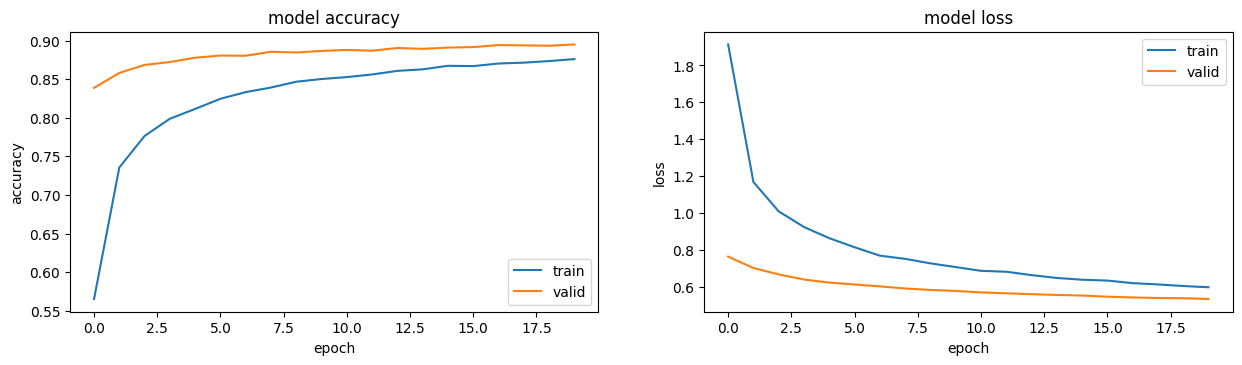


Hyperparameters: [[1.28e+02 1.00e-03 1.00e-03 1.00e+00 0.00e+00 2.00e-01]]
313/313 [==============================] - 1s 2ms/step - loss: 0.3596 - accuracy: 0.9068

Epoch 1: val_accuracy improved from -inf to 0.87190, saving model to cifar10.h5

Epoch 2: val_accuracy did not improve from 0.87190

Epoch 3: ReduceLROnPlateau reducing learning rate to 0.0006000000284984708.

Epoch 3: val_accuracy did not improve from 0.87190

Epoch 4: val_accuracy improved from 0.87190 to 0.88840, saving model to cifar10.h5

Epoch 5: val_accuracy improved from 0.88840 to 0.88910, saving model to cifar10.h5

Epoch 6: val_accuracy improved from 0.88910 to 0.89110, saving model to cifar10.h5

Epoch 7: val_accuracy did not improve from 0.89110

Epoch 8: val_accuracy improved from 0.89110 to 0.89580, saving model to cifar10.h5

Epoch 9: val_accuracy did not improve from 0.89580

Epoch 10: ReduceLROnPlateau reducing learning rate to 0.0003600000170990825.

Epoch 10: val_accuracy did not improve from 0.89580

E

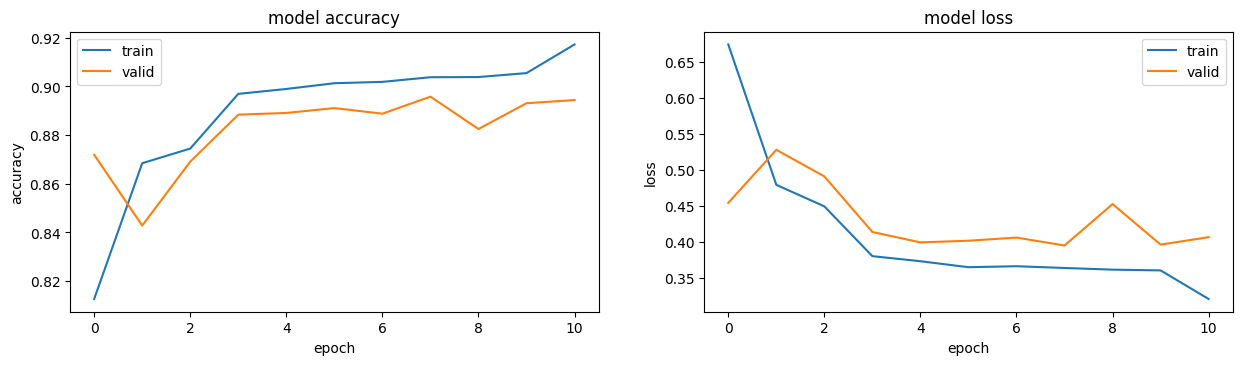


Hyperparameters: [[1.28e+02 1.00e-06 1.00e-03 2.00e+00 2.00e+00 2.00e-01]]
313/313 [==============================] - 1s 2ms/step - loss: 0.3596 - accuracy: 0.9068

Epoch 1: val_accuracy improved from -inf to 0.08550, saving model to cifar10.h5

Epoch 2: val_accuracy improved from 0.08550 to 0.09740, saving model to cifar10.h5

Epoch 3: val_accuracy improved from 0.09740 to 0.10670, saving model to cifar10.h5

Epoch 4: val_accuracy improved from 0.10670 to 0.11610, saving model to cifar10.h5

Epoch 5: val_accuracy improved from 0.11610 to 0.12690, saving model to cifar10.h5

Epoch 6: val_accuracy improved from 0.12690 to 0.13900, saving model to cifar10.h5

Epoch 7: val_accuracy improved from 0.13900 to 0.14830, saving model to cifar10.h5

Epoch 8: val_accuracy improved from 0.14830 to 0.15960, saving model to cifar10.h5

Epoch 9: val_accuracy improved from 0.15960 to 0.16980, saving model to cifar10.h5

Epoch 10: val_accuracy improved from 0.16980 to 0.18130, saving model to cifar10.

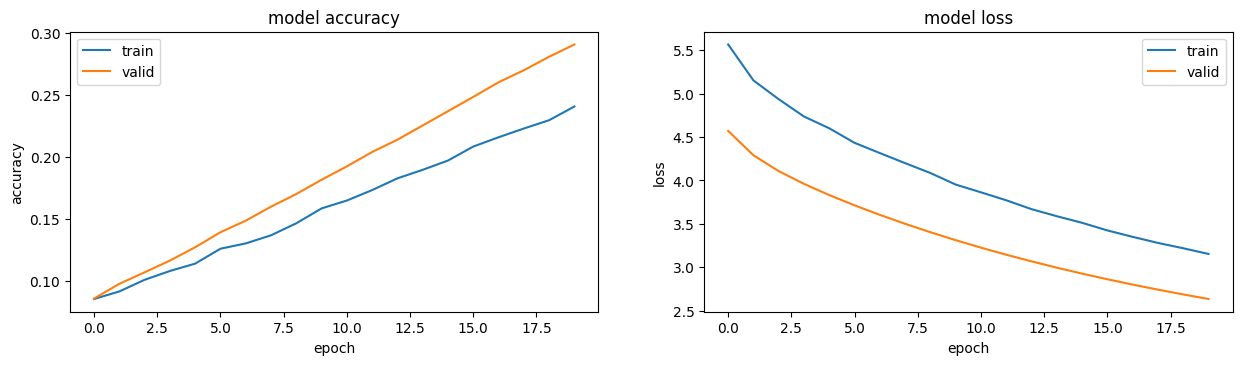


Hyperparameters: [[5.12e+02 1.00e-04 1.00e-02 1.00e+00 1.00e+00 5.00e-01]]
313/313 [==============================] - 1s 2ms/step - loss: 0.3596 - accuracy: 0.9068

Epoch 1: val_accuracy improved from -inf to 0.86780, saving model to cifar10.h5

Epoch 2: val_accuracy improved from 0.86780 to 0.88660, saving model to cifar10.h5

Epoch 3: val_accuracy did not improve from 0.88660

Epoch 4: val_accuracy improved from 0.88660 to 0.89550, saving model to cifar10.h5

Epoch 5: val_accuracy improved from 0.89550 to 0.89570, saving model to cifar10.h5

Epoch 6: val_accuracy did not improve from 0.89570

Epoch 7: ReduceLROnPlateau reducing learning rate to 5.999999848427251e-05.

Epoch 7: val_accuracy did not improve from 0.89570

Epoch 8: val_accuracy improved from 0.89570 to 0.90120, saving model to cifar10.h5

Epoch 9: val_accuracy did not improve from 0.90120

Epoch 10: ReduceLROnPlateau reducing learning rate to 3.599999909056351e-05.

Epoch 10: val_accuracy did not improve from 0.90120

E

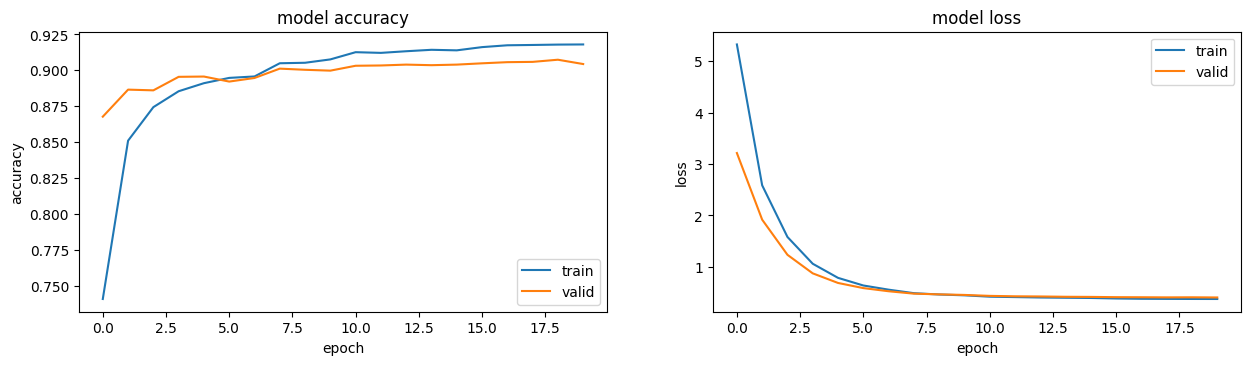


Hyperparameters: [[5.12e+02 1.00e-03 1.00e-03 1.00e+00 2.00e+00 2.00e-01]]
313/313 [==============================] - 1s 2ms/step - loss: 0.3596 - accuracy: 0.9068

Epoch 1: val_accuracy improved from -inf to 0.84760, saving model to cifar10.h5

Epoch 2: val_accuracy improved from 0.84760 to 0.86440, saving model to cifar10.h5

Epoch 3: val_accuracy improved from 0.86440 to 0.87120, saving model to cifar10.h5

Epoch 4: val_accuracy improved from 0.87120 to 0.87590, saving model to cifar10.h5

Epoch 5: val_accuracy improved from 0.87590 to 0.88010, saving model to cifar10.h5

Epoch 6: val_accuracy improved from 0.88010 to 0.88430, saving model to cifar10.h5

Epoch 7: val_accuracy improved from 0.88430 to 0.88590, saving model to cifar10.h5

Epoch 8: val_accuracy improved from 0.88590 to 0.88680, saving model to cifar10.h5

Epoch 9: val_accuracy improved from 0.88680 to 0.88980, saving model to cifar10.h5

Epoch 10: val_accuracy improved from 0.88980 to 0.89190, saving model to cifar10.

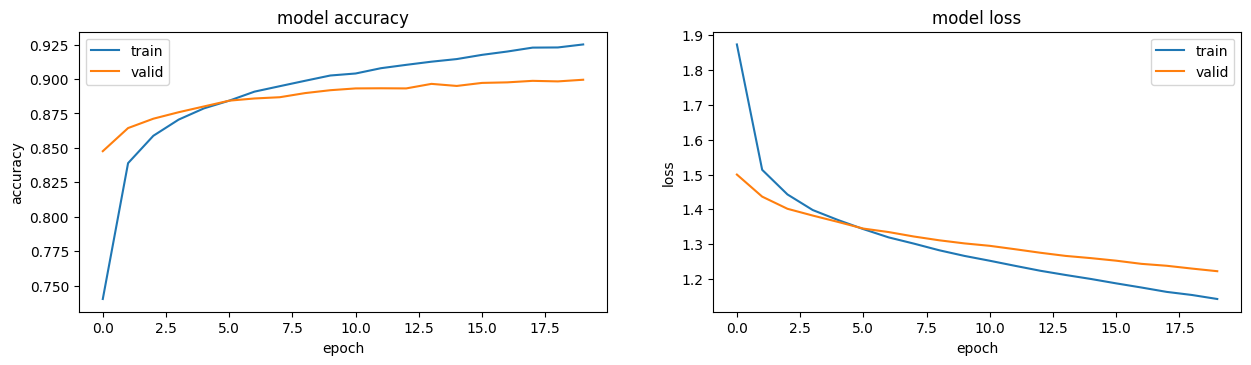


Hyperparameters: [[5.12e+02 1.00e-05 1.00e-01 2.00e+00 0.00e+00 5.00e-01]]
313/313 [==============================] - 1s 2ms/step - loss: 0.3596 - accuracy: 0.9068

Epoch 1: val_accuracy improved from -inf to 0.78520, saving model to cifar10.h5

Epoch 2: val_accuracy improved from 0.78520 to 0.83320, saving model to cifar10.h5

Epoch 3: val_accuracy improved from 0.83320 to 0.85310, saving model to cifar10.h5

Epoch 4: val_accuracy improved from 0.85310 to 0.86500, saving model to cifar10.h5

Epoch 5: val_accuracy improved from 0.86500 to 0.87480, saving model to cifar10.h5

Epoch 6: val_accuracy improved from 0.87480 to 0.88210, saving model to cifar10.h5

Epoch 7: val_accuracy improved from 0.88210 to 0.88380, saving model to cifar10.h5

Epoch 8: val_accuracy improved from 0.88380 to 0.88770, saving model to cifar10.h5

Epoch 9: val_accuracy did not improve from 0.88770

Epoch 10: ReduceLROnPlateau reducing learning rate to 5.999999848427251e-06.

Epoch 10: val_accuracy did not impr

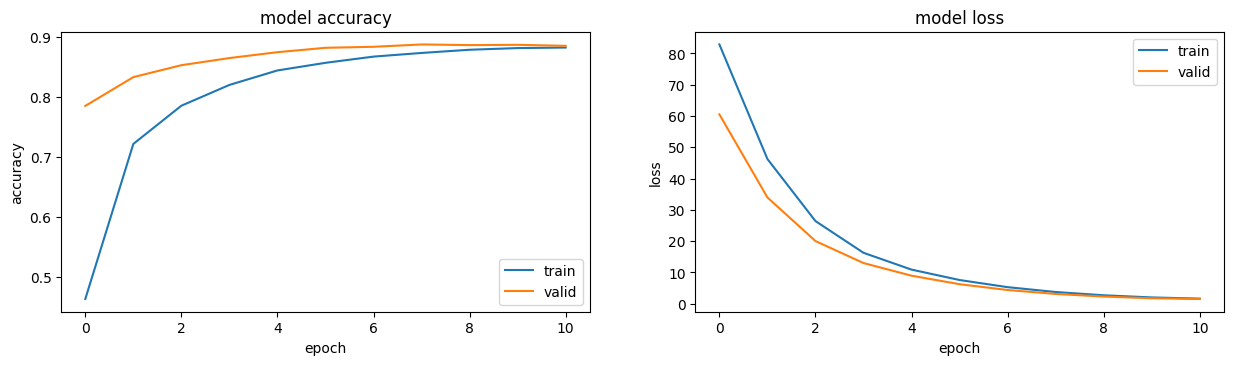


Hyperparameters: [[5.12e+02 1.00e-04 1.00e-02 3.00e+00 0.00e+00 7.00e-01]]
313/313 [==============================] - 1s 2ms/step - loss: 0.3596 - accuracy: 0.9068

Epoch 1: val_accuracy improved from -inf to 0.86390, saving model to cifar10.h5

Epoch 2: val_accuracy improved from 0.86390 to 0.88180, saving model to cifar10.h5

Epoch 3: val_accuracy improved from 0.88180 to 0.88560, saving model to cifar10.h5

Epoch 4: val_accuracy improved from 0.88560 to 0.88780, saving model to cifar10.h5

Epoch 5: val_accuracy improved from 0.88780 to 0.89340, saving model to cifar10.h5

Epoch 6: val_accuracy did not improve from 0.89340

Epoch 7: ReduceLROnPlateau reducing learning rate to 5.999999848427251e-05.

Epoch 7: val_accuracy did not improve from 0.89340

Epoch 8: val_accuracy did not improve from 0.89340
Epoch 8: early stopping
313/313 [==============================] - 1s 2ms/step - loss: 0.4898 - accuracy: 0.8927

LOSS:	0.48980775475502014 	 ACCURACY:	0.8927000164985657
[0.48980775475

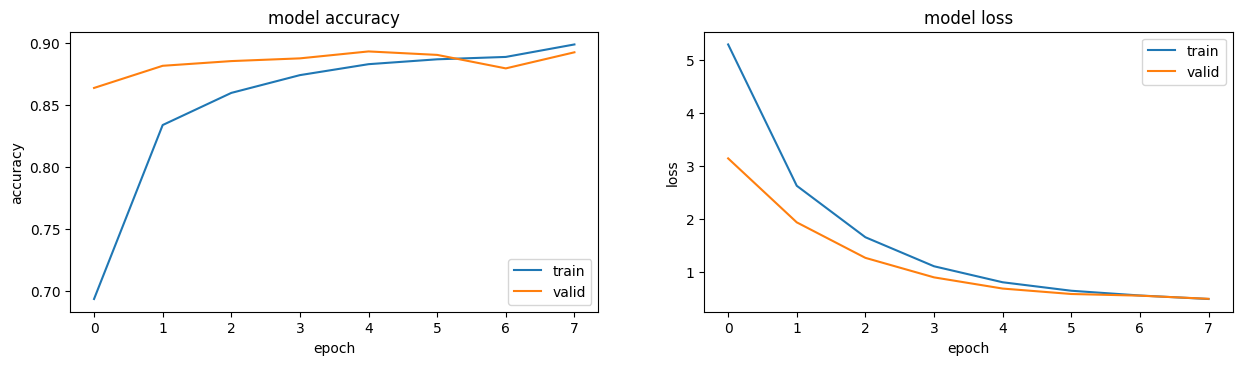


Hyperparameters: [[5.12e+02 1.00e-04 1.00e-01 1.00e+00 0.00e+00 2.00e-01]]
313/313 [==============================] - 1s 2ms/step - loss: 0.3596 - accuracy: 0.9068

Epoch 1: val_accuracy improved from -inf to 0.86800, saving model to cifar10.h5

Epoch 2: val_accuracy did not improve from 0.86800

Epoch 3: ReduceLROnPlateau reducing learning rate to 5.999999848427251e-05.

Epoch 3: val_accuracy did not improve from 0.86800

Epoch 4: val_accuracy did not improve from 0.86800
Epoch 4: early stopping
313/313 [==============================] - 1s 2ms/step - loss: 0.8127 - accuracy: 0.8651

LOSS:	0.8127310276031494 	 ACCURACY:	0.8651000261306763
[0.8127310276031494, 0.8651000261306763]



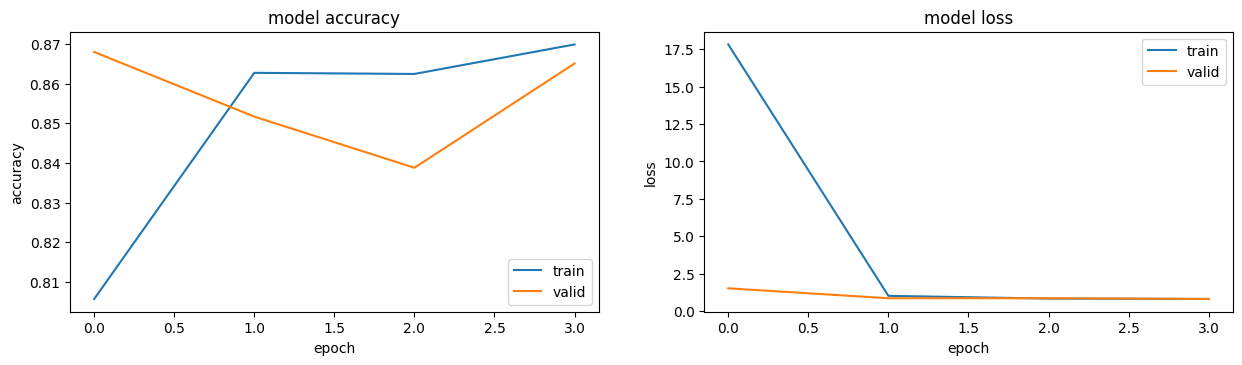


Hyperparameters: [[5.12e+02 1.00e-06 1.00e-01 1.00e+00 2.00e+00 2.00e-01]]
313/313 [==============================] - 1s 2ms/step - loss: 0.3596 - accuracy: 0.9068

Epoch 1: val_accuracy improved from -inf to 0.14950, saving model to cifar10.h5

Epoch 2: val_accuracy improved from 0.14950 to 0.15630, saving model to cifar10.h5

Epoch 3: val_accuracy improved from 0.15630 to 0.16930, saving model to cifar10.h5

Epoch 4: val_accuracy improved from 0.16930 to 0.18040, saving model to cifar10.h5

Epoch 5: val_accuracy improved from 0.18040 to 0.19250, saving model to cifar10.h5

Epoch 6: val_accuracy improved from 0.19250 to 0.20660, saving model to cifar10.h5

Epoch 7: val_accuracy improved from 0.20660 to 0.21840, saving model to cifar10.h5

Epoch 8: val_accuracy improved from 0.21840 to 0.23050, saving model to cifar10.h5

Epoch 9: val_accuracy improved from 0.23050 to 0.24200, saving model to cifar10.h5

Epoch 10: val_accuracy improved from 0.24200 to 0.25410, saving model to cifar10.

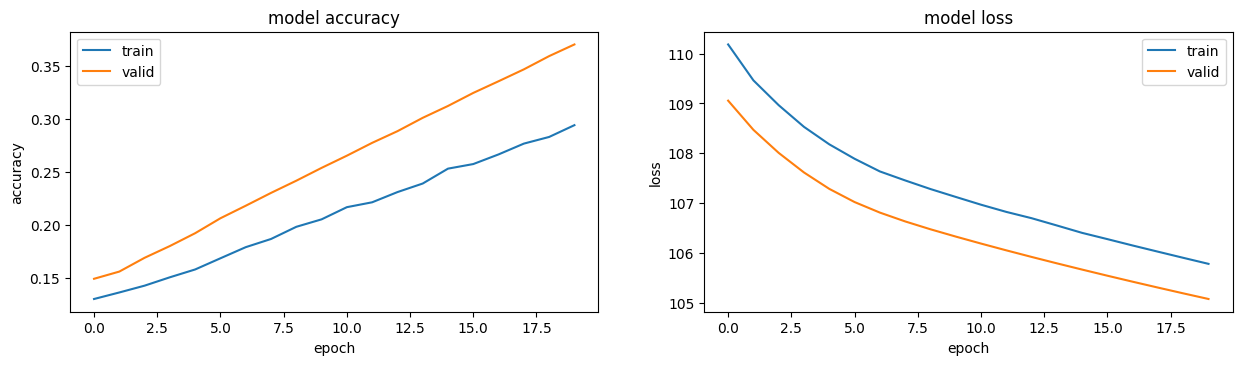


Hyperparameters: [[2.56e+02 1.00e-04 1.00e-03 1.00e+00 0.00e+00 2.00e-01]]
313/313 [==============================] - 1s 2ms/step - loss: 0.3596 - accuracy: 0.9068

Epoch 1: val_accuracy improved from -inf to 0.86240, saving model to cifar10.h5

Epoch 2: val_accuracy improved from 0.86240 to 0.88090, saving model to cifar10.h5

Epoch 3: val_accuracy improved from 0.88090 to 0.88530, saving model to cifar10.h5

Epoch 4: val_accuracy improved from 0.88530 to 0.89090, saving model to cifar10.h5

Epoch 5: val_accuracy improved from 0.89090 to 0.89720, saving model to cifar10.h5

Epoch 6: val_accuracy did not improve from 0.89720

Epoch 7: val_accuracy improved from 0.89720 to 0.89750, saving model to cifar10.h5

Epoch 8: val_accuracy improved from 0.89750 to 0.89770, saving model to cifar10.h5

Epoch 9: val_accuracy improved from 0.89770 to 0.90410, saving model to cifar10.h5

Epoch 10: val_accuracy did not improve from 0.90410

Epoch 11: val_accuracy improved from 0.90410 to 0.90480, sav

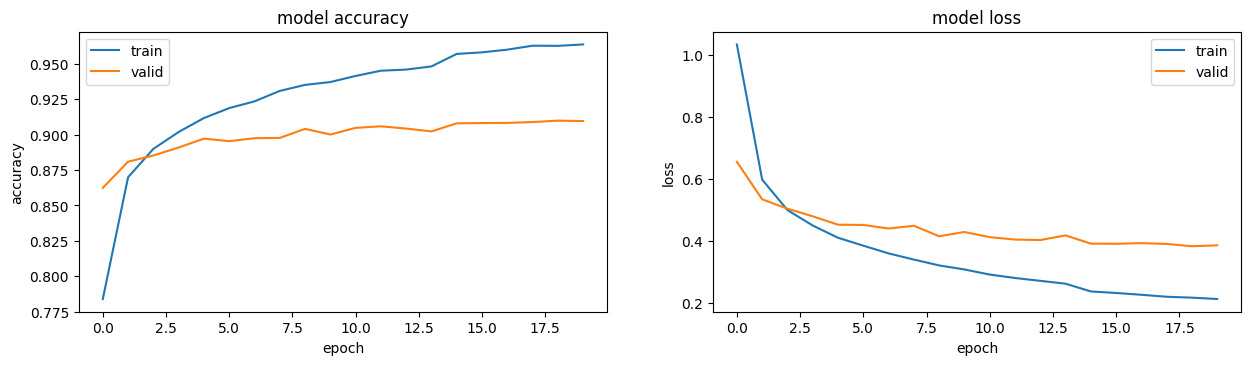


Hyperparameters: [[2.56e+02 1.00e-04 1.00e-03 3.00e+00 0.00e+00 5.00e-01]]
313/313 [==============================] - 1s 2ms/step - loss: 0.3848 - accuracy: 0.9096

Epoch 1: val_accuracy improved from -inf to 0.86070, saving model to cifar10.h5

Epoch 2: val_accuracy improved from 0.86070 to 0.87690, saving model to cifar10.h5

Epoch 3: val_accuracy improved from 0.87690 to 0.88070, saving model to cifar10.h5

Epoch 4: val_accuracy improved from 0.88070 to 0.89030, saving model to cifar10.h5

Epoch 5: val_accuracy improved from 0.89030 to 0.89270, saving model to cifar10.h5

Epoch 6: val_accuracy improved from 0.89270 to 0.89620, saving model to cifar10.h5

Epoch 7: val_accuracy did not improve from 0.89620

Epoch 8: val_accuracy improved from 0.89620 to 0.89820, saving model to cifar10.h5

Epoch 9: val_accuracy did not improve from 0.89820

Epoch 10: val_accuracy improved from 0.89820 to 0.89950, saving model to cifar10.h5

Epoch 11: val_accuracy did not improve from 0.89950

Epoch 1

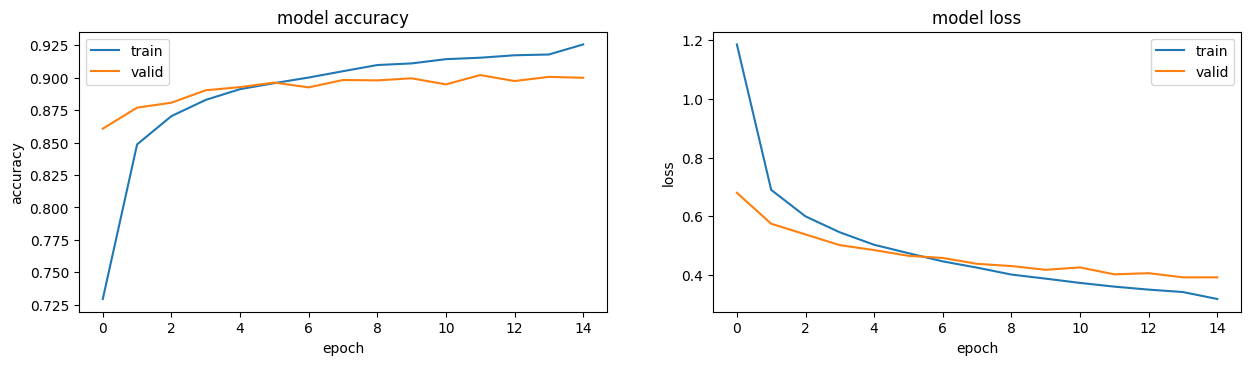


Hyperparameters: [[2.56e+02 1.00e-03 1.00e-03 3.00e+00 1.00e+00 2.00e-01]]
313/313 [==============================] - 1s 2ms/step - loss: 0.3848 - accuracy: 0.9096

Epoch 1: val_accuracy improved from -inf to 0.85200, saving model to cifar10.h5

Epoch 2: val_accuracy improved from 0.85200 to 0.85750, saving model to cifar10.h5

Epoch 3: val_accuracy improved from 0.85750 to 0.86880, saving model to cifar10.h5

Epoch 4: val_accuracy did not improve from 0.86880

Epoch 5: ReduceLROnPlateau reducing learning rate to 0.0006000000284984708.

Epoch 5: val_accuracy did not improve from 0.86880

Epoch 6: val_accuracy improved from 0.86880 to 0.88120, saving model to cifar10.h5

Epoch 7: val_accuracy improved from 0.88120 to 0.88280, saving model to cifar10.h5

Epoch 8: val_accuracy improved from 0.88280 to 0.88920, saving model to cifar10.h5

Epoch 9: val_accuracy did not improve from 0.88920

Epoch 10: ReduceLROnPlateau reducing learning rate to 0.0003600000170990825.

Epoch 10: val_accuracy

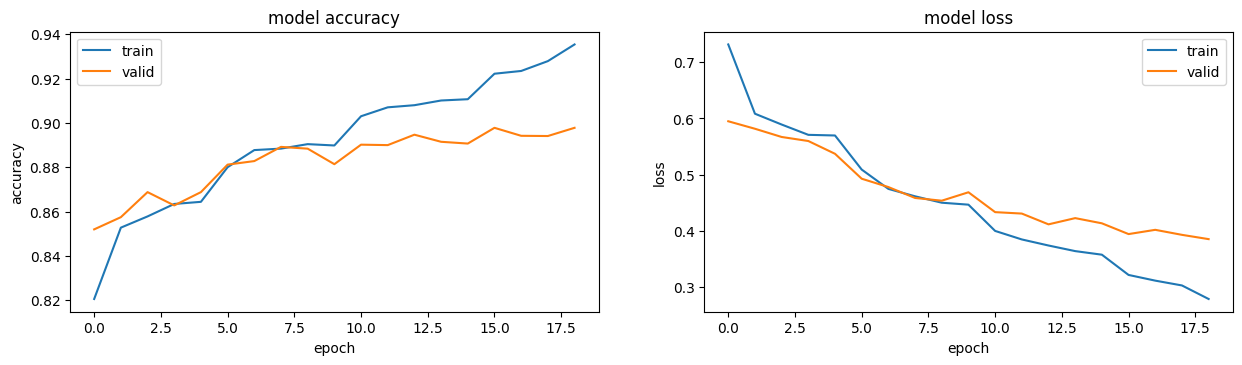


Hyperparameters: [[2.56e+02 1.00e-06 1.00e-01 2.00e+00 1.00e+00 2.00e-01]]
313/313 [==============================] - 1s 2ms/step - loss: 0.3848 - accuracy: 0.9096

Epoch 1: val_accuracy improved from -inf to 0.23510, saving model to cifar10.h5

Epoch 2: val_accuracy improved from 0.23510 to 0.38920, saving model to cifar10.h5

Epoch 3: val_accuracy improved from 0.38920 to 0.50740, saving model to cifar10.h5

Epoch 4: val_accuracy improved from 0.50740 to 0.58610, saving model to cifar10.h5

Epoch 5: val_accuracy improved from 0.58610 to 0.64290, saving model to cifar10.h5

Epoch 6: val_accuracy improved from 0.64290 to 0.68250, saving model to cifar10.h5

Epoch 7: val_accuracy improved from 0.68250 to 0.71140, saving model to cifar10.h5

Epoch 8: val_accuracy improved from 0.71140 to 0.73430, saving model to cifar10.h5

Epoch 9: val_accuracy improved from 0.73430 to 0.74960, saving model to cifar10.h5

Epoch 10: val_accuracy improved from 0.74960 to 0.75970, saving model to cifar10.

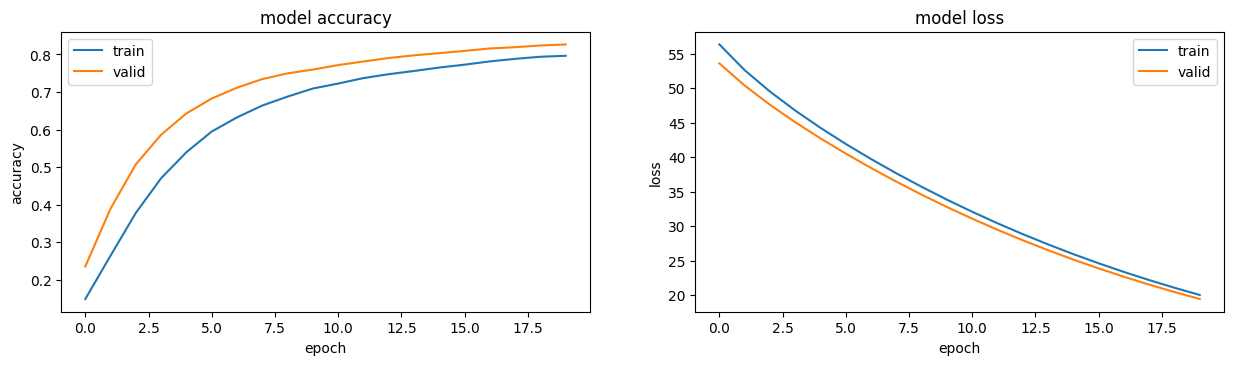


Hyperparameters: [[2.56e+02 1.00e-03 1.00e-01 3.00e+00 2.00e+00 5.00e-01]]
313/313 [==============================] - 1s 2ms/step - loss: 0.3848 - accuracy: 0.9096

Epoch 1: val_accuracy improved from -inf to 0.83490, saving model to cifar10.h5

Epoch 2: val_accuracy improved from 0.83490 to 0.86050, saving model to cifar10.h5

Epoch 3: val_accuracy improved from 0.86050 to 0.87120, saving model to cifar10.h5

Epoch 4: val_accuracy improved from 0.87120 to 0.87830, saving model to cifar10.h5

Epoch 5: val_accuracy did not improve from 0.87830

Epoch 6: val_accuracy improved from 0.87830 to 0.88150, saving model to cifar10.h5

Epoch 7: val_accuracy improved from 0.88150 to 0.88210, saving model to cifar10.h5

Epoch 8: val_accuracy did not improve from 0.88210

Epoch 9: val_accuracy improved from 0.88210 to 0.88470, saving model to cifar10.h5

Epoch 10: val_accuracy did not improve from 0.88470

Epoch 11: ReduceLROnPlateau reducing learning rate to 0.0006000000284984708.

Epoch 11: val_

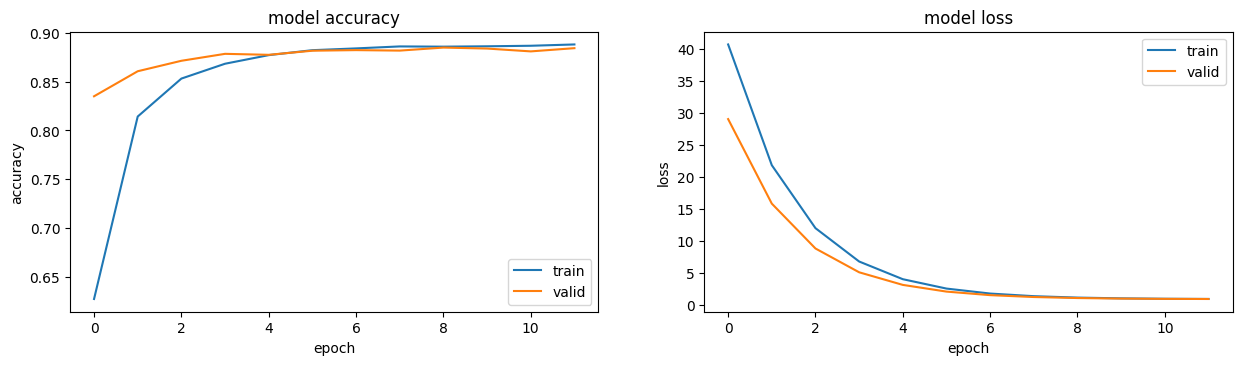


Hyperparameters: [[2.56e+02 1.00e-06 1.00e-02 3.00e+00 0.00e+00 5.00e-01]]
313/313 [==============================] - 1s 2ms/step - loss: 0.3848 - accuracy: 0.9096

Epoch 1: val_accuracy improved from -inf to 0.24250, saving model to cifar10.h5

Epoch 2: val_accuracy improved from 0.24250 to 0.36060, saving model to cifar10.h5

Epoch 3: val_accuracy improved from 0.36060 to 0.46100, saving model to cifar10.h5

Epoch 4: val_accuracy improved from 0.46100 to 0.53810, saving model to cifar10.h5

Epoch 5: val_accuracy improved from 0.53810 to 0.59460, saving model to cifar10.h5

Epoch 6: val_accuracy improved from 0.59460 to 0.63680, saving model to cifar10.h5

Epoch 7: val_accuracy improved from 0.63680 to 0.66990, saving model to cifar10.h5

Epoch 8: val_accuracy improved from 0.66990 to 0.69340, saving model to cifar10.h5

Epoch 9: val_accuracy improved from 0.69340 to 0.71220, saving model to cifar10.h5

Epoch 10: val_accuracy improved from 0.71220 to 0.72820, saving model to cifar10.

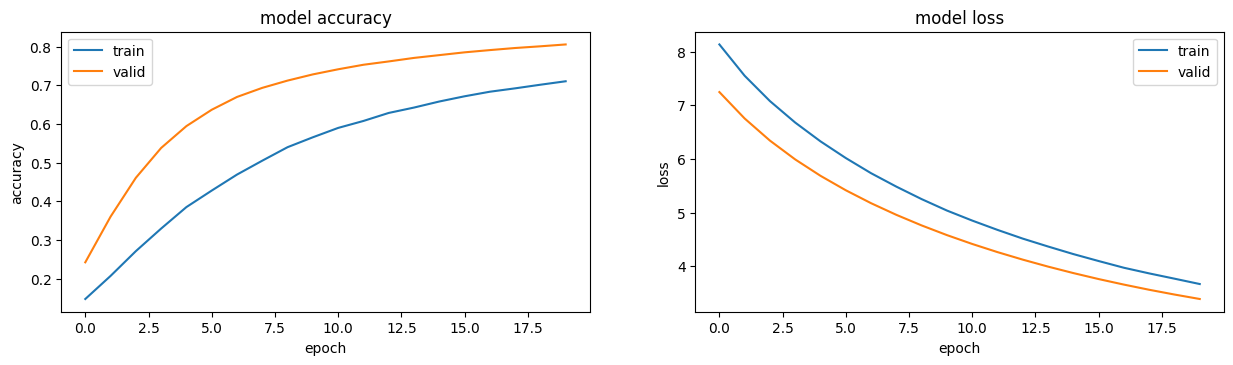

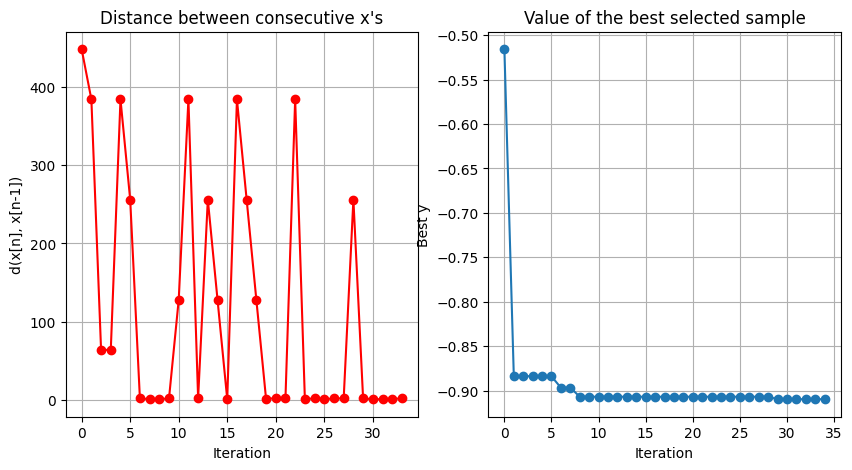

In [32]:
# define the kernel for the Bayesian surrogate model using the "radial basis function" (RBF)
kernel = GPy.kern.RBF(input_dim=1, variance=1.0, lengthscale=1.0)
# hyperparameter bounds
bounds = [{'name': 'units', 'type': 'discrete', 'domain': (64, 128, 256, 512)}, 
          {'name': 'learning_rate', 'type': 'discrete', 'domain': (1e-3, 1e-4, 1e-5, 1e-6)}, 
          {'name': 'l2', 'type': 'discrete', 'domain': (1e-1, 1e-2, 1e-3)}, 
          {'name': 'activation', 'type': 'discrete', 'domain': (1, 2, 3)},
          {'name': 'opt', 'type': 'discrete', 'domain': (0,1,2)}, 
          {'name': 'rate', 'type': 'discrete', 'domain': (0.2, 0.5, 0.7)}]
# Note: 'activation' domain parameters (1, 2, 3) correspond to strings ('relu', 'elu', 'tanh'); dictionary defined in build_model()

# objective function for the model optimization:
def f(x):
  """objective function of the Bayesian surrogate model"""
  print()
  print("Hyperparameters:", x)
  # Retrieve 'accuracy' from the previously saved model
  try:
    previous_best_model = keras.models.load_model('cifar10_best.h5')
    previous_evaluation = evaluate_model(previous_best_model)
  except Exception:
    previous_best_model = None
  model, lr_reduce, early_stop, checkpoint = build_model(
                                        units=int(x[:,0]),
                                        learning_rate=float(x[:,1]),
                                        l2=float(x[:,2]),
                                        activation=int(x[:,3]),
                                        opt=int(x[:,4]),
                                        rate=float(x[:,5]))
  history = fit_model(model, lr_reduce, early_stop, checkpoint)

  evaluation = evaluate_model(model)
  print()
  print("LOSS:\t{0} \t ACCURACY:\t{1}".format(evaluation[0],
  evaluation[1]))
  print(evaluation)
  print()


  # compare previous and current validation accuracies
  if not previous_best_model:
    keras.models.save_model(model, 'cifar10_best.h5', overwrite=False,
    include_optimizer=True)
  if previous_best_model and evaluation[1] > previous_evaluation[1]:
    keras.models.save_model(model, 'cifar10_best.h5', overwrite=True,
    include_optimizer=True)
  # Get the dictionary containing each metric and the loss for each   epoch
  # history_dict = history.history
  # print(history_dict)


  # """function that plots the model loss and accuracy"""
  def plot_history(history):
      plt.figure(1, figsize = (15,8))
      plt.subplot(221)
      plt.plot(history.history['accuracy'])
      plt.plot(history.history['val_accuracy'])
      plt.title('model accuracy')
      plt.ylabel('accuracy')
      plt.xlabel('epoch')
      plt.legend(['train', 'valid'])
      plt.subplot(222)
      plt.plot(history.history['loss'])
      plt.plot(history.history['val_loss'])
      plt.title('model loss')
      plt.ylabel('loss')
      plt.xlabel('epoch')
      plt.legend(['train', 'valid'])
      plt.show()
  # plot the model accuracy and loss results
  plot_history(history)
  # delete the instantiated models from memory and clear the session
  del model
  del previous_best_model
  keras.backend.clear_session()
  return evaluation[1]

# Initializing X and Y, and adding noise (if need be)
# X_init = np.array([[int(16)]])
# Y_init = f(X_init)
# noise = 0.2
optimizer = BayesianOptimization(f=f,
                                 domain=bounds,
                                 model_type='GP',
                                 kernel=kernel,
                                 acquisition_type ='EI',
                                 acquisition_jitter = 0.01,
                                 # X=X_init,
                                 # Y=-Y_init,
                                 # noise_var = noise**2,
                                 exact_feval=False,
                                 normalize_Y=False,
                                 maximize=True,
                                 verbosity=False)
print()
print("=====================")
print("=====================")
print()
optimizer.run_optimization(max_iter=30, verbosity=False)
optimizer.plot_acquisition()
optimizer.plot_convergence()
optimizer.save_report('bayes_opt.txt')



In [42]:
# print optimized model
activation_dict = {1: 'relu', 2: 'elu', 3: 'tanh'}
optimizer_dict = {0: 'rmsprop', 1: 'adam', 2: 'sgd'}
print("""
Optimized Parameters:
\t{0}:\t{1}
\t{2}:\t{3}
\t{4}:\t{5}
\t{6}:\t{7}
\t{8}:\t{9}
\t{10}:\t{11}
""".format(bounds[0]["name"], optimizer.x_opt[0],
           bounds[1]["name"], optimizer.x_opt[1],
           bounds[2]["name"], optimizer.x_opt[2],
           bounds[3]["name"], activation_dict[optimizer.x_opt[3]],
           bounds[4]["name"], optimizer_dict[optimizer.x_opt[4]],
           bounds[5]["name"], optimizer.x_opt[5]))

print("optimized accuracy: {0}".format(abs(optimizer.fx_opt)))


Optimized Parameters:
	units:	256.0
	learning_rate:	0.0001
	l2:	0.001
	activation:	relu
	opt:	rmsprop
	rate:	0.2

optimized accuracy: 0.909600019454956


In [34]:
# reinstantiate the best model from saved file
best_model = keras.models.load_model('cifar10_best.h5')
best_model.summary()
loss, acc = best_model.evaluate(features_valid, y_test)
print('Restored model, accuracy: {:5.2f}%'.format(100*acc))

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 1920)]            0         
                                                                 
 dense (Dense)               (None, 256)               491776    
                                                                 
 dropout (Dropout)           (None, 256)               0         
                                                                 
 dense_1 (Dense)             (None, 10)                2570      
                                                                 
Total params: 494,346
Trainable params: 494,346
Non-trainable params: 0
_________________________________________________________________
313/313 [==============================] - 1s 2ms/step - loss: 0.3848 - accuracy: 0.9096
Restored model, accuracy: 90.96%


In [35]:
best_model.evaluate(features_valid, y_test)

313/313 [==============================] - 1s 2ms/step - loss: 0.3848 - accuracy: 0.9096


[0.38483500480651855, 0.909600019454956]

In [36]:
data_path = 'bayes_opt.txt'
with open(data_path, 'r') as f:
  lines = f.read().split('\n')
for line in lines:
  print(line)

----------------------------- GPyOpt Report file -----------------------------------
GPyOpt Version 1.2.6
Date and time:               Sun Apr 16 00:00:49 2023
Optimization completed:      NO,35 samples collected.
Number initial samples:      5 
Tolerance:                   1e-08.
Optimization time:           1981.8240973949432 seconds.

-------------------------------- Problem set up ------------------------------------
Problem name:                no_name
Problem dimension:           6
Number continuous variables  0
Number discrete variables    6
Number bandits               0
Noiseless evaluations:       False
Cost used:                   User defined cost
Constraints:                  False

------------------------------ Optimization set up ---------------------------------
Normalized outputs:          False
Model type:                  GP
Model update interval:       1
Acquisition type:            EI
Acquisition optimizer:       lbfgs
Acquisition type:            EI
Acquisition o